# Mid-Term Project

#### Overview
- Use Medicare CCLF Claims from Syntegra dataset to answer key business questions
- Extra credit for building up on the questions below (additional questions + answers)
- One Jupyter notebook solution with clear Python code and all cell outputs available
- At least two data quality checks

## Step 0. Prepare raw input datasets

Here we will 1) load original datasets, 2) remove unused columns, 3) de-duplicate rows, and 4) join datasets, not necessarily in this order

Assumptions: 
- Claim ID (cur_clm_uniq_id) represents one claim, which may or may not have more than one code (code could be HCPCS/CPT, diagnosis, procedure...)
- There is a one-to-many relationship between patient IDs (bene_mbi_id) and claim IDs (cur_clm_uniq_id), i.e. each claim is unique to one patient, but one patient can have more than one claim

### 0.1 Import required packages

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Turn off the automatic setting that redacts the columns/rows from the dataframe output
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', 200)

### 0.2 Load & select columns to be used from raw (original) datasets

### 0.2.1 Load & select columns from Claims Header dataset

In [3]:
# Load Claims Header dataset
parta_claims_header_raw_df = pd.read_csv("parta_claims_header.csv")
parta_claims_header_raw_df.sort_values(by=['cur_clm_uniq_id'])

,cur_clm_uniq_id,prvdr_oscar_num,bene_mbi_id,bene_hic_num,clm_type_cd,clm_from_dt,clm_thru_dt,clm_bill_fac_type_cd,clm_bill_clsfctn_cd,prncpl_dgns_cd,admtg_dgns_cd,clm_mdcr_npmt_rsn_cd,clm_pmt_amt,clm_nch_prmry_pyr_cd,prvdr_fac_fips_st_cd,bene_ptnt_stus_cd,dgns_drg_cd,clm_op_srvc_type_cd,fac_prvdr_npi_num,oprtg_prvdr_npi_num,atndg_prvdr_npi_num,othr_prvdr_npi_num,clm_adjsmt_type_cd,clm_efctv_dt,clm_idr_ld_dt,bene_eqtbl_bic_hicn_num,clm_admsn_type_cd,clm_admsn_src_cd,clm_bill_freq_cd,clm_query_cd,dgns_prcdr_icd_ind,clm_mdcr_instnl_tot_chrg_amt,clm_mdcr_ip_pps_cptl_ime_amt,clm_oprtnl_ime_amt,clm_mdcr_ip_pps_dsprprtnt_amt,clm_hipps_uncompd_care_amt,clm_oprtnl_dsprtnt_amt
510,100190,111821,1228,NaN,40,2018-06-10,2018-06-10,7,7,M1611,NaN,NaN,127.79,NaN,11,1,NaN,F,1780608992,NaN,1.972732e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,0,415.80,NaN,NaN,NaN,NaN,NaN
521,100402,100226,1261,NaN,60,2017-05-27,2017-06-02,1,1,K5733,K5733,NaN,10602.46,NaN,10,6,330.0,NaN,1689611501,NaN,1.285688e+09,NaN,NaN,NaN,NaN,NaN,1.0,1,1,3,0,70795.63,609.13,0.00,13.92,231.15,NaN
525,100464,360051,12978,NaN,40,2017-06-26,2017-06-26,1,3,R079,NaN,NaN,199.45,NaN,36,1,NaN,C,1073688354,NaN,1.982693e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,0,2709.80,NaN,NaN,NaN,NaN,NaN
536,100698,140276,11789,NaN,40,2017-07-28,2017-07-28,1,3,M545,NaN,NaN,85.25,NaN,14,1,NaN,C,1376521575,NaN,1.912991e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,0,115.00,NaN,NaN,NaN,NaN,NaN
540,100750,230216,12138,NaN,40,2018-01-13,2018-01-13,1,3,Z0289,NaN,N,0.00,NaN,23,9,NaN,C,1982685384,NaN,1.063442e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0,226.00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,1698691,390145,10007,NaN,40,2016-12-11,2016-12-11,1,3,Z01818,NaN,NaN,43.01,NaN,39,1,NaN,C,1689691214,NaN,1.679505e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,0,235.00,NaN,NaN,NaN,NaN,NaN
4365,1698722,200021,10985,NaN,40,2018-06-16,2018-06-16,1,3,E782,NaN,NaN,179.09,NaN,20,1,NaN,C,1932164795,NaN,1.548289e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,0,1939.35,NaN,NaN,NaN,NaN,NaN
4366,1698935,210022,1297,NaN,40,2018-04-06,2018-04-06,1,3,I110,NaN,NaN,400.81,NaN,21,9,NaN,C,1205896446,NaN,1.922016e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,0,554.00,NaN,NaN,NaN,NaN,NaN
4367,1699005,100057,12194,NaN,40,2016-04-27,2016-04-27,1,3,I348,NaN,NaN,265.19,NaN,10,1,NaN,C,1821019571,NaN,1.437130e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,0,8423.00,NaN,NaN,NaN,NaN,NaN


#### Data Quality Check #1: If true, the original dataset was unique on claim ID

In [4]:
parta_claims_header_raw_df_count = parta_claims_header_raw_df.shape[0]
parta_claims_header_raw_uniq_clm_id_df = parta_claims_header_raw_df['cur_clm_uniq_id'].drop_duplicates()

parta_claims_header_raw_df_count == parta_claims_header_raw_uniq_clm_id_df.shape[0]

True

In [5]:
# Select only the desired columns (renaming if needed) and remove duplicates if any
parta_claims_header_df = parta_claims_header_raw_df[[
    'cur_clm_uniq_id', 'bene_mbi_id', 'atndg_prvdr_npi_num', 
    'clm_from_dt', 'prncpl_dgns_cd', 'clm_pmt_amt'
]].drop_duplicates().rename(
    columns={
        'cur_clm_uniq_id': 'claim_id',
        'bene_mbi_id': 'patient_id',
        'clm_from_dt': 'claim_date',
        'atndg_prvdr_npi_num': 'npi_id'
    }
)
parta_claims_header_df

,claim_id,patient_id,npi_id,claim_date,prncpl_dgns_cd,clm_pmt_amt
0,1001595,10226,1.366492e+09,2018-02-28,M25551,259.01
1,1004555,10133,1.942275e+09,2018-11-02,Z9861,29.56
2,1011605,10163,1.578546e+09,2018-01-02,C439,45.88
3,1011758,1003,1.952368e+09,2018-06-12,R310,9.40
4,101424,10052,1.336125e+09,2016-04-13,L821,34.18
...,...,...,...,...,...,...
8621,999774,10367,NaN,2017-11-06,R072,374.08
8622,999808,10496,1.740225e+09,2017-07-19,R079,360.89
8623,999878,12160,1.497784e+09,2018-01-18,R5383,90.73
8624,999961,12090,1.083691e+09,2018-03-10,C73,329.44


#### Data Quality Check #2: If true, the filtered dataset did not have any duplicates

In [6]:
parta_claims_header_df_count = parta_claims_header_df.shape[0]

parta_claims_header_raw_df_count == parta_claims_header_df_count

True

#### Data Quality Check #3: If the resulting dataframe is empty, it means all the records have diagnosis code (if it's not empty it should be removed now since we want only the ones with valid codes for analysis)

In [7]:
parta_claims_header_df.loc[~parta_claims_header_df.prncpl_dgns_cd.notnull()]

,claim_id,patient_id,npi_id,claim_date,prncpl_dgns_cd,clm_pmt_amt


### 0.2.2 Load & select columns from Claims Revenue Center dataset

In [8]:
# Load Claims Revenue Center dataset
# Note this dataset has more than one record for each claim ID (cur_clm_uniq_id)
# Also note there are two sets of date columns, 
#  one for claim ID (clm_from/thru_dt) and one for claim line (clm_line_from/thru_dt)
parta_claims_revenue_center_detail_raw_df = pd.read_csv(
    "parta_claims_revenue_center_detail.csv"
)
parta_claims_revenue_center_detail_raw_df.sort_values(by=['cur_clm_uniq_id'])

/var/folders/p3/gcmm6pn51fz4s623ws8v6t9m0000gn/T/ipykernel_19930/578682904.py:5: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  parta_claims_revenue_center_detail_raw_df = pd.read_csv(


,cur_clm_uniq_id,clm_line_num,bene_mbi_id,bene_hic_num,clm_type_cd,clm_line_from_dt,clm_line_thru_dt,clm_line_prod_rev_ctr_cd,clm_line_instnl_rev_ctr_dt,clm_line_hcpcs_cd,bene_eqtbl_bic_hicn_num,prvdr_oscar_num,clm_from_dt,clm_thru_dt,clm_line_srvc_unit_qty,clm_line_cvrd_pd_amt,hcpcs_1_mdfr_cd,hcpcs_2_mdfr_cd,hcpcs_3_mdfr_cd,hcpcs_4_mdfr_cd,hcpcs_5_mdfr_cd,clm_rev_apc_hipps_cd
318,100073,1,12620,NaN,40,2018-12-02 00:00:00,2018-12-02 00:00:00,403,2018-12-02 00:00:00,77063,NaN,NaN,2018-12-02 00:00:00,2018-12-02 00:00:00,1,24.11,NaN,NaN,NaN,NaN,NaN,00000
383,100184,1,10080,NaN,40,2018-09-06 00:00:00,2018-09-06 00:00:00,1,NaN,NaN,NaN,NaN,2018-09-06 00:00:00,2018-09-06 00:00:00,0,0.00,NaN,NaN,NaN,NaN,NaN,00000
384,100190,1,1228,NaN,40,2018-06-10 00:00:00,2018-06-10 00:00:00,521,2018-06-10 00:00:00,G0467,NaN,NaN,2018-06-10 00:00:00,2018-06-10 00:00:00,1,133.74,NaN,NaN,NaN,NaN,NaN,00000
385,100190,2,1228,NaN,40,2018-06-10 00:00:00,2018-06-10 00:00:00,521,2018-06-10 00:00:00,98960,NaN,NaN,2018-06-10 00:00:00,2018-06-10 00:00:00,1,0.00,NaN,NaN,NaN,NaN,NaN,00000
386,100190,3,1228,NaN,40,2018-06-10 00:00:00,2018-06-10 00:00:00,521,2018-06-10 00:00:00,J1100,NaN,NaN,2018-06-10 00:00:00,2018-06-10 00:00:00,4,0.00,NaN,NaN,NaN,NaN,NaN,00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29896,1699197,2,1177,NaN,40,2016-05-22 00:00:00,2016-05-22 00:00:00,302,2016-05-22 00:00:00,86592,NaN,NaN,2016-05-22 00:00:00,2016-05-22 00:00:00,1,5.43,NaN,NaN,NaN,NaN,NaN,00000
29898,1699212,1,1262,NaN,60,2018-12-24 00:00:00,2018-12-25 00:00:00,730,NaN,NaN,NaN,NaN,2018-12-24 00:00:00,2018-12-25 00:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,00000
29901,1699236,3,10580,NaN,40,2017-09-20 00:00:00,2017-09-20 00:00:00,370,2017-09-20 00:00:00,NaN,NaN,NaN,2017-09-20 00:00:00,2017-09-20 00:00:00,2,0.00,NaN,NaN,NaN,NaN,NaN,00000
29899,1699236,1,10580,NaN,40,2017-09-20 00:00:00,2017-09-20 00:00:00,258,2017-09-20 00:00:00,NaN,NaN,NaN,2017-09-20 00:00:00,2017-09-20 00:00:00,1,0.00,NaN,NaN,NaN,NaN,NaN,00000


#### Data Quality Check #4: If the resulting dataframe is empty, it means there is no difference between columns 'clm_line_from_dt' and 'clm_from_dt' for all the rows

In [9]:
parta_claims_revenue_center_detail_raw_df.loc[
    ~(parta_claims_revenue_center_detail_raw_df['clm_line_from_dt'] 
      == parta_claims_revenue_center_detail_raw_df['clm_from_dt'])
]

,cur_clm_uniq_id,clm_line_num,bene_mbi_id,bene_hic_num,clm_type_cd,clm_line_from_dt,clm_line_thru_dt,clm_line_prod_rev_ctr_cd,clm_line_instnl_rev_ctr_dt,clm_line_hcpcs_cd,bene_eqtbl_bic_hicn_num,prvdr_oscar_num,clm_from_dt,clm_thru_dt,clm_line_srvc_unit_qty,clm_line_cvrd_pd_amt,hcpcs_1_mdfr_cd,hcpcs_2_mdfr_cd,hcpcs_3_mdfr_cd,hcpcs_4_mdfr_cd,hcpcs_5_mdfr_cd,clm_rev_apc_hipps_cd


In [10]:
# Select only the desired columns (renaming if needed) and remove duplicates if any
# Select 'clm_from_dt' as the column for claim dates since we want uniqueness on claim ID, not claim line
parta_claims_revenue_center_detail_df = parta_claims_revenue_center_detail_raw_df[[
    'cur_clm_uniq_id', 'bene_mbi_id', 'clm_from_dt',
    'clm_line_hcpcs_cd', 'clm_line_cvrd_pd_amt'
]].drop_duplicates().rename(
    columns={
        'cur_clm_uniq_id': 'claim_id',
        'bene_mbi_id': 'patient_id',
        'clm_from_dt': 'claim_date',
        'clm_line_hcpcs_cd': 'hcpcs_code'
    }
)
parta_claims_revenue_center_detail_df

,claim_id,patient_id,claim_date,hcpcs_code,clm_line_cvrd_pd_amt
0,1001122,10081,2018-05-30 00:00:00,NaN,0.00
1,1001595,10226,2018-02-28 00:00:00,G0283,9.67
7,1001595,10226,2018-02-28 00:00:00,G8978,0.00
8,1001595,10226,2018-02-28 00:00:00,G8979,0.00
10,1001595,10226,2018-02-28 00:00:00,97110,24.97
...,...,...,...,...,...
59414,999961,12090,2018-03-10 00:00:00,A9516,0.00
59415,999961,12090,2018-03-10 00:00:00,G8996,0.00
59416,999976,10768,2016-01-18 00:00:00,80053,11.37
59417,999976,10768,2016-01-18 00:00:00,80061,12.83


#### Data Quality Check #5: If the resulting dataframe is empty, it means all the records have HCPCS code (if it's not empty it should be removed now since we want only the ones with valid codes for analysis)

In [11]:
parta_claims_revenue_center_detail_df.loc[
    ~parta_claims_revenue_center_detail_df.hcpcs_code.notnull()
]

,claim_id,patient_id,claim_date,hcpcs_code,clm_line_cvrd_pd_amt
0,1001122,10081,2018-05-30 00:00:00,NaN,0.0
25,1001595,10226,2018-02-28 00:00:00,NaN,0.0
29,1004555,10133,2018-11-02 00:00:00,NaN,0.0
30,1004904,10106,2018-02-26 00:00:00,NaN,0.0
32,100974,10042,2017-02-20 00:00:00,NaN,0.0
...,...,...,...,...,...
59369,999008,12473,2018-08-04 00:00:00,NaN,0.0
59402,999774,10367,2017-11-06 00:00:00,NaN,0.0
59407,999808,10496,2017-07-19 00:00:00,NaN,0.0
59410,999943,11021,2016-11-20 00:00:00,NaN,0.0


In [12]:
# Data Quality Check #5 failed, so remove rows with no HCPCS codes
parta_claims_revenue_center_detail_df = parta_claims_revenue_center_detail_df.loc[
    parta_claims_revenue_center_detail_df.hcpcs_code.notnull()
]

In [13]:
# Update date format for claim dates to match that of Claims Header dataset for easy join
parta_claims_revenue_center_detail_df['claim_date'] = pd.to_datetime(
    parta_claims_revenue_center_detail_df['claim_date']
).dt.strftime('%Y-%m-%d')
parta_claims_revenue_center_detail_df

/var/folders/p3/gcmm6pn51fz4s623ws8v6t9m0000gn/T/ipykernel_19930/2671745514.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parta_claims_revenue_center_detail_df['claim_date'] = pd.to_datetime(


,claim_id,patient_id,claim_date,hcpcs_code,clm_line_cvrd_pd_amt
1,1001595,10226,2018-02-28,G0283,9.67
7,1001595,10226,2018-02-28,G8978,0.00
8,1001595,10226,2018-02-28,G8979,0.00
10,1001595,10226,2018-02-28,97110,24.97
18,1001595,10226,2018-02-28,97140,20.33
...,...,...,...,...,...
59413,999961,12090,2018-03-10,78014,400.05
59414,999961,12090,2018-03-10,A9516,0.00
59415,999961,12090,2018-03-10,G8996,0.00
59416,999976,10768,2016-01-18,80053,11.37


#### Mini-Analysis #1: Find whether there are matching claims between Claim Header and Claims Revenue Center datasets

                                                ***

In [14]:
claims_header_unique_claims_df = parta_claims_header_df[[
    'claim_id'
]].drop_duplicates()

claims_header_unique_claims_df['header'] = 1

revenue_center_unique_claims_df = parta_claims_revenue_center_detail_df[[
    'claim_id'
]].drop_duplicates()

revenue_center_unique_claims_df['revenue'] = 1

joined_df1 = pd.merge(
    claims_header_unique_claims_df,
    revenue_center_unique_claims_df,
    on='claim_id', how = 'outer'
)
joined_df1

,claim_id,header,revenue
0,1001595,1.0,1.0
1,1004555,1.0,1.0
2,1011605,1.0,1.0
3,1011758,1.0,1.0
4,101424,1.0,NaN
...,...,...,...
15721,999074,NaN,1.0
15722,999324,NaN,1.0
15723,999350,NaN,1.0
15724,999514,NaN,1.0


In [15]:
print('# of unique claims in Claims Header dataset: ' 
      + str(claims_header_unique_claims_df.shape[0])
     )
print('# of unique claims in Claims Revenue Center dataset: ' 
      + str(revenue_center_unique_claims_df.shape[0])
     )

# of unique claims in Claims Header dataset: 8626
# of unique claims in Claims Revenue Center dataset: 13406


In [16]:
print('# of unique claims in Claims Header and Claims Revenue Center datasets combined: ' 
      + str(joined_df1.shape[0])
     )
print('From combined list of unique claims - ')
print('# of unique claims in only Claims Header dataset: ' 
      + str(joined_df1.loc[(joined_df1.header == 1) & ~(joined_df1.revenue == 1)].shape[0])
     )
print('# of unique claims in only Claims Revenue Center dataset: ' 
      + str(joined_df1.loc[~(joined_df1.header == 1) & (joined_df1.revenue == 1)].shape[0])
     )
print('# of unique claims in both Claims Header AND Claims Revenue Center datasets: ' 
      + str(joined_df1.loc[(joined_df1.header == 1) & (joined_df1.revenue == 1)].shape[0])
     )

# of unique claims in Claims Header and Claims Revenue Center datasets combined: 15726
From combined list of unique claims - 
# of unique claims in only Claims Header dataset: 2320
# of unique claims in only Claims Revenue Center dataset: 7100
# of unique claims in both Claims Header AND Claims Revenue Center datasets: 6306


Conclusion: There are quite a number of claims available in both datasets, so join them on claim ID as an outer join to get all possible claims without duplicates

                                                ***

### 0.2.3 Load & select columns from Diagnosis dataset

In [17]:
# Load the Diagnosis dataset
# Note that 'clm_from_dt' has some records with null values, but we need claim dates for all claims
parta_diagnosis_code_raw_df = pd.read_csv("parta_diagnosis_code.csv")
parta_diagnosis_code_raw_df.sort_values(by=['cur_clm_uniq_id', 'clm_val_sqnc_num'])

,cur_clm_uniq_id,bene_mbi_id,bene_hic_num,clm_type_cd,clm_prod_type_cd,clm_val_sqnc_num,clm_dgns_cd,bene_eqtbl_bic_hicn_num,prvdr_oscar_num,clm_from_dt,clm_thru_dt,clm_poa_ind,dgns_prcdr_icd_ind
244,100190,1228,NaN,40,NaN,1,M1611,NaN,NaN,NaN,2018-06-10 00:00:00,NaN,0
243,100190,1228,NaN,40,NaN,2,M25572,NaN,NaN,NaN,2018-06-10 00:00:00,NaN,0
246,100190,1228,NaN,40,NaN,3,M25551,NaN,NaN,NaN,2018-06-10 00:00:00,NaN,0
245,100190,1228,NaN,40,NaN,4,M5136,NaN,NaN,NaN,2018-06-10 00:00:00,NaN,0
366,100402,1261,NaN,60,NaN,11,E119,NaN,100256.0,2017-05-28 00:00:00,2017-06-02 00:00:00,Y,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16232,1699102,11842,NaN,60,NaN,13,Z8673,NaN,330191.0,2017-01-31 00:00:00,2017-02-03 00:00:00,0,0
16236,1699137,10873,NaN,40,NaN,1,N390,NaN,NaN,NaN,2018-07-12 00:00:00,NaN,0
16235,1699137,10873,NaN,40,NaN,2,N390,NaN,NaN,NaN,2018-07-12 00:00:00,NaN,0
16237,1699155,11689,NaN,40,NaN,3,K219,NaN,NaN,NaN,2018-12-06 00:00:00,NaN,0


In [18]:
# Select only the desired columns (renaming if needed) and remove duplicates if any
# Use 'clm_thru_dt' as claim date columns since 'clm_from_dt' has some nulls
parta_diagnosis_code_df = parta_diagnosis_code_raw_df[[
    'cur_clm_uniq_id', 'bene_mbi_id', 'clm_thru_dt', 'clm_dgns_cd'
]].drop_duplicates().rename(
    columns={
        'cur_clm_uniq_id': 'claim_id',
        'bene_mbi_id': 'patient_id',
        'clm_thru_dt': 'claim_date'
    }
)
parta_diagnosis_code_df

,claim_id,patient_id,claim_date,clm_dgns_cd
0,1001122,10081,2018-05-30 00:00:00,K5289
1,1001595,10226,2018-02-28 00:00:00,M25551
2,1001595,10226,2018-02-28 00:00:00,M79604
3,1001865,10133,2018-09-14 00:00:00,G459
4,1004555,10133,2018-11-02 00:00:00,Z9861
...,...,...,...,...
32047,999878,12160,2018-01-18 00:00:00,N390
32048,999943,11021,2016-11-20 00:00:00,M545
32049,999961,12090,2018-03-10 00:00:00,C73
32050,999962,11030,2018-07-17 00:00:00,G8194


#### Data Quality Check #6: If the resulting dataframe is empty, it means all the records have values for 'clm_thru_dt' (if it's not empty it should be removed now since without claim dates it'd be difficult to use)

In [19]:
parta_diagnosis_code_df.loc[~parta_diagnosis_code_df.claim_date.notnull()]

,claim_id,patient_id,claim_date,clm_dgns_cd


#### Data Quality Check #7: If the resulting dataframe is empty, it means all the records have diagnosis code (if it's not empty it should be removed now since we want only the ones with valid codes for analysis)

In [20]:
parta_diagnosis_code_df.loc[~parta_diagnosis_code_df.clm_dgns_cd.notnull()]

,claim_id,patient_id,claim_date,clm_dgns_cd


In [21]:
# Update date format for claim dates to match that of Claims Header dataset for easy join
parta_diagnosis_code_df['claim_date'] = pd.to_datetime(
    parta_diagnosis_code_df['claim_date']
).dt.strftime('%Y-%m-%d')
parta_diagnosis_code_df

,claim_id,patient_id,claim_date,clm_dgns_cd
0,1001122,10081,2018-05-30,K5289
1,1001595,10226,2018-02-28,M25551
2,1001595,10226,2018-02-28,M79604
3,1001865,10133,2018-09-14,G459
4,1004555,10133,2018-11-02,Z9861
...,...,...,...,...
32047,999878,12160,2018-01-18,N390
32048,999943,11021,2016-11-20,M545
32049,999961,12090,2018-03-10,C73
32050,999962,11030,2018-07-17,G8194


#### Mini-Analysis #2: Find whether there are matching claims between above two datasets and the Diagnosis dataset

                                                ***

In [22]:
diagnosis_unique_claims_df = parta_diagnosis_code_df[[
    'claim_id'
]].drop_duplicates()

diagnosis_unique_claims_df['diagnosis'] = 1

joined_df2 = pd.merge(
    joined_df1,
    diagnosis_unique_claims_df,
    on='claim_id', how = 'outer'
)
joined_df2

,claim_id,header,revenue,diagnosis
0,1001595,1.0,1.0,1.0
1,1004555,1.0,1.0,1.0
2,1011605,1.0,1.0,1.0
3,1011758,1.0,1.0,1.0
4,101424,1.0,NaN,NaN
...,...,...,...,...
19452,998726,NaN,NaN,1.0
19453,999064,NaN,NaN,1.0
19454,999766,NaN,NaN,1.0
19455,999799,NaN,NaN,1.0


In [23]:
print('# of unique claims in Claims Header+Claims Revenue Center datasets: ' 
      + str(joined_df1.shape[0])
     )
print('# of unique claims in Diagnosis dataset: ' 
      + str(diagnosis_unique_claims_df.shape[0])
     )

# of unique claims in Claims Header+Claims Revenue Center datasets: 15726
# of unique claims in Diagnosis dataset: 13432


In [24]:
print('# of unique claims in Claims Header+Claims Revenue Center and Diagnosis datasets combined: ' 
      + str(joined_df2.shape[0])
     )
print('From combined list of unique claims - ')
print('# of unique claims only in either Claims Header or Claims Revenue Center datasets: ' 
      + str(joined_df2.loc[
          ((joined_df2.header == 1) | (joined_df2.revenue == 1))
          & ~(joined_df2.diagnosis == 1)
      ].shape[0])
     )
print('# of unique claims in only Diagnosis dataset: ' 
      + str(joined_df2.loc[
          (~(joined_df2.header == 1) & ~(joined_df2.revenue == 1))
          & (joined_df2.diagnosis == 1)
      ].shape[0])
     )
print('# of unique claims in all three datasets: ' 
      + str(joined_df2.loc[
          (joined_df2.header == 1) & (joined_df2.revenue == 1) & (joined_df2.diagnosis == 1)
      ].shape[0])
     )

# of unique claims in Claims Header+Claims Revenue Center and Diagnosis datasets combined: 19457
From combined list of unique claims - 
# of unique claims only in either Claims Header or Claims Revenue Center datasets: 6025
# of unique claims in only Diagnosis dataset: 3731
# of unique claims in all three datasets: 5266


Conclusion: There are quite a number of claims available in all three datasets, so join diagnosis to the first two datasets on claim ID as an outer join to get all possible claims without duplicates

                                                ***

### 0.2.4 Load & select columns from Procedure dataset

In [25]:
# Load the Procedure dataset
parta_procedure_code_df = pd.read_csv("parta_procedure_code.csv")
parta_procedure_code_df

,cur_clm_uniq_id,bene_mbi_id,bene_hic_num,clm_type_cd,clm_val_sqnc_num,clm_prcdr_cd,clm_prcdr_prfrm_dt,bene_eqtbl_bic_hicn_num,prvdr_oscar_num,clm_from_dt,clm_thru_dt,dgns_prcdr_icd_ind
0,100402,1261,NaN,60,1,0DJD8ZZ,2017-05-31 00:00:00,NaN,100256,2017-05-28 00:00:00,2017-06-02 00:00:00,0
1,100402,1261,NaN,60,2,0D9670Z,2017-05-29 00:00:00,NaN,100256,2017-05-28 00:00:00,2017-06-02 00:00:00,0
2,100402,1261,NaN,60,3,0DJD8ZZ,2017-06-01 00:00:00,NaN,100256,2017-05-28 00:00:00,2017-06-02 00:00:00,0
3,100402,1261,NaN,60,4,0DB78ZX,2017-05-30 00:00:00,NaN,100256,2017-05-28 00:00:00,2017-06-02 00:00:00,0
4,1008371,1074,NaN,60,1,0T9B7ZZ,2016-12-03 00:00:00,NaN,140007,2016-12-02 00:00:00,2016-12-08 00:00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...
457,357821,10200,NaN,60,2,4A023N7,2018-06-18 00:00:00,NaN,100258,2018-06-16 00:00:00,2018-06-19 00:00:00,0
458,357821,10200,NaN,60,1,4A023N7,2018-06-18 00:00:00,NaN,100258,2018-06-16 00:00:00,2018-06-19 00:00:00,0
459,412998,10106,NaN,60,1,0SRC0J9,2016-12-09 00:00:00,NaN,250104,2016-12-09 00:00:00,2016-12-10 00:00:00,0
460,460114,10133,NaN,60,1,0QSH04Z,2018-05-17 00:00:00,NaN,150112,2018-05-07 00:00:00,2018-05-23 00:00:00,0


Conclusion: Don't join procedure dataset since the only useful info for sake of this analysis is the procedure codes and we won't be using them in our analysis

### 0.2.5 Load & select columns from DME dataset

In [26]:
# Load the DME dataset
partb_dme_raw_df = pd.read_csv("partb_dme.csv")
partb_dme_raw_df.sort_values(by='cur_clm_uniq_id')

,cur_clm_uniq_id,clm_line_num,bene_mbi_id,bene_hic_num,clm_type_cd,clm_from_dt,clm_thru_dt,clm_fed_type_srvc_cd,clm_pos_cd,clm_line_from_dt,clm_line_thru_dt,clm_line_hcpcs_cd,clm_line_cvrd_pd_amt,clm_prmry_pyr_cd,payto_prvdr_npi_num,ordrg_prvdr_npi_num,clm_carr_pmt_dnl_cd,clm_prcsg_ind_cd,clm_adjsmt_type_cd,clm_efctv_dt,clm_idr_ld_dt,clm_cntl_num,bene_eqtbl_bic_hicn_num,clm_line_alowd_chrg_amt,clm_disp_cd
267,100441,1,12064,NaN,82,2016-10-10,2016-10-10,P,12,2016-10-10,2016-10-10,A4256,3.24,NaN,1972744431,1.407814e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,3.98,1
268,100441,2,12064,NaN,82,2016-10-10,2016-10-10,P,12,2016-10-10,2016-10-10,E0607,59.80,NaN,1972744431,1.407814e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,76.54,1
269,100441,3,12064,NaN,82,2016-10-10,2016-10-10,P,12,2016-10-10,2016-10-10,A4253,38.57,NaN,1972744431,1.407814e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,49.92,1
270,100441,4,12064,NaN,82,2016-10-10,2016-10-10,P,12,2016-10-10,2016-10-10,A4259,4.20,NaN,1972744431,1.407814e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,4.80,1
271,100441,5,12064,NaN,82,2016-10-10,2016-10-10,P,12,2016-10-10,2016-10-10,A4258,2.27,NaN,1972744431,1.407814e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,2.84,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1541,1696080,2,11689,NaN,82,2016-11-18,2016-11-18,P,12,2016-11-18,2016-11-18,A7038,0.00,NaN,1376599084,1.659342e+09,0,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1
129,1696545,1,10046,NaN,82,2017-07-25,2017-07-25,R,12,2017-07-25,2017-07-25,E0570,6.30,NaN,1346347374,1.952397e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,8.12,1
1548,1696792,1,12086,NaN,82,2018-12-23,2018-12-23,P,12,2018-12-23,2018-12-23,A4604,35.58,NaN,1790823722,1.518936e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,48.17,1
1549,1697987,1,11074,NaN,82,2018-04-06,2018-04-06,P,12,2018-04-06,2018-04-06,A4253,27.92,NaN,1902842065,1.750382e+09,1,NaN,NaN,NaN,NaN,NaN,NaN,33.28,1


In [27]:
# Select only the desired columns (rename columns if needed) and remove duplicates if any
partb_dme_df = partb_dme_raw_df[[
    'cur_clm_uniq_id', 'bene_mbi_id', 'ordrg_prvdr_npi_num',
    'clm_from_dt', 'clm_line_hcpcs_cd', 'clm_line_alowd_chrg_amt'
]].drop_duplicates().rename(
    columns={
        'cur_clm_uniq_id': 'claim_id',
        'bene_mbi_id': 'patient_id',
        'ordrg_prvdr_npi_num': 'npi_id',
        'clm_from_dt': 'claim_date',
        'clm_line_hcpcs_cd': 'hcpcs_code',
        'clm_line_alowd_chrg_amt': 'claim_cost'
    }
)
partb_dme_df

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,claim_cost
0,1004024,10202,1.841430e+09,2016-07-18,E0601,41.91
1,1034063,10137,1.669460e+09,2016-04-22,E0601,62.46
2,1046877,10202,1.093713e+09,2016-02-03,E0601,29.31
3,1072934,10202,1.285602e+09,2016-08-15,E0601,27.82
4,1082554,10174,1.003895e+09,2016-08-30,E0431,18.75
...,...,...,...,...,...,...
2770,998097,10396,1.891706e+09,2016-12-06,A4253,69.69
2771,999226,1095,1.518066e+09,2017-12-28,A4256,3.68
2772,999226,1095,1.518066e+09,2017-12-28,A4253,49.92
2773,999226,1095,1.518066e+09,2017-12-28,A4259,4.26


#### Data Quality Check #8: If the resulting dataframe is empty, it means all the records have HCPCS code (if it's not empty it should be removed now since we want only the ones with valid codes for analysis)

In [28]:
partb_dme_df.loc[~partb_dme_df.hcpcs_code.notnull()]

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,claim_cost


#### Mini-Analysis #3: Find whether there are matching claims between the first three datasets above and the DME dataset

                                                ***

In [29]:
dme_unique_claims_df = partb_dme_df[[
    'claim_id'
]].drop_duplicates()

dme_unique_claims_df['dme'] = 1

joined_df3 = pd.merge(
    joined_df2,
    dme_unique_claims_df,
    on='claim_id', how = 'outer'
)
joined_df3

,claim_id,header,revenue,diagnosis,dme
0,1001595,1.0,1.0,1.0,NaN
1,1004555,1.0,1.0,1.0,NaN
2,1011605,1.0,1.0,1.0,NaN
3,1011758,1.0,1.0,1.0,NaN
4,101424,1.0,NaN,NaN,NaN
...,...,...,...,...,...
20960,994844,NaN,NaN,NaN,1.0
20961,994885,NaN,NaN,NaN,1.0
20962,998097,NaN,NaN,NaN,1.0
20963,999226,NaN,NaN,NaN,1.0


In [30]:
print('# of unique claims in first three datasets: ' 
      + str(joined_df2.shape[0])
     )
print('# of unique claims in DME dataset: ' 
      + str(dme_unique_claims_df.shape[0])
     )

# of unique claims in first three datasets: 19457
# of unique claims in DME dataset: 1508


In [31]:
print('# of unique claims in the four datasets combined: ' 
      + str(joined_df3.shape[0])
     )
print('From combined list of unique claims - ')
print('# of unique claims in only the first three datasets: ' 
      + str(joined_df3.loc[
          ((joined_df3.header == 1) 
          | (joined_df3.revenue == 1)
          | (joined_df3.diagnosis == 1))
          & ~(joined_df3.dme == 1)
      ].shape[0])
     )
print('# of unique claims in only DME dataset: ' 
      + str(joined_df3.loc[
          ~(joined_df3.header == 1) 
          & ~(joined_df3.revenue == 1)
          & ~(joined_df3.diagnosis == 1)
          & (joined_df3.dme == 1)
      ].shape[0])
     )
print('# of unique claims in all four datasets: ' 
      + str(joined_df3.loc[
          (joined_df3.header == 1) 
          & (joined_df3.revenue == 1)
          & (joined_df3.diagnosis == 1)
          & (joined_df3.dme == 1)
      ].shape[0])
     )
print('# of unique claims in DME and any of the first three datasets: ' 
      + str(joined_df3.loc[
          ((joined_df3.header == 1) 
          | (joined_df3.revenue == 1)
          | (joined_df3.diagnosis == 1))
          & (joined_df3.dme == 1)
      ].shape[0])
     )

# of unique claims in the four datasets combined: 20965
From combined list of unique claims - 
# of unique claims in only the first three datasets: 19457
# of unique claims in only DME dataset: 1508
# of unique claims in all four datasets: 0
# of unique claims in DME and any of the first three datasets: 0


Conclusion: None of the claims from DME is in any of the first three datasets, so append them to the output after joining the first three datasets

                                                ***

### 0.2.6 Load & select columns from Physicians dataset

In [32]:
# Load the Physicians dataset
partb_physicians_raw_df = pd.read_csv("partb_physicians.csv")
partb_physicians_raw_df.sort_values(by='cur_clm_uniq_id')

,cur_clm_uniq_id,clm_line_num,bene_mbi_id,bene_hic_num,clm_type_cd,clm_from_dt,clm_thru_dt,rndrg_prvdr_type_cd,rndrg_prvdr_fips_st_cd,clm_prvdr_spclty_cd,clm_fed_type_srvc_cd,clm_pos_cd,clm_line_from_dt,clm_line_thru_dt,clm_line_hcpcs_cd,clm_line_cvrd_pd_amt,clm_line_prmry_pyr_cd,clm_line_dgns_cd,clm_rndrg_prvdr_tax_num,rndrg_prvdr_npi_num,clm_carr_pmt_dnl_cd,clm_prcsg_ind_cd,clm_adjsmt_type_cd,clm_efctv_dt,clm_idr_ld_dt,clm_cntl_num,bene_eqtbl_bic_hicn_num,clm_line_alowd_chrg_amt,clm_line_srvc_unit_qty,hcpcs_1_mdfr_cd,hcpcs_2_mdfr_cd,hcpcs_3_mdfr_cd,hcpcs_4_mdfr_cd,hcpcs_5_mdfr_cd,clm_disp_cd,clm_dgns_1_cd,clm_dgns_2_cd,clm_dgns_3_cd,clm_dgns_4_cd,clm_dgns_5_cd,clm_dgns_6_cd,clm_dgns_7_cd,clm_dgns_8_cd,dgns_prcdr_icd_ind,clm_dgns_9_cd,clm_dgns_10_cd,clm_dgns_11_cd,clm_dgns_12_cd,hcpcs_betos_cd
520,100020,1,1070,NaN,71,2016-10-04,2016-10-04,5,36,69,5,81,2016-10-04,2016-10-04,85610,5.10,NaN,I482,NaN,1.619972e+09,1,A,NaN,NaN,NaN,NaN,NaN,5.49,1.0,NaN,NaN,NaN,NaN,NaN,1,I482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,T1H
525,100024,1,11654,NaN,71,2016-12-10,2016-12-10,1,39,26,T,11,2016-12-10,2016-12-10,90834,61.17,NaN,F319,NaN,1.811965e+09,1,A,NaN,NaN,NaN,NaN,NaN,79.36,1.0,NaN,NaN,NaN,NaN,NaN,1,F319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,M5B
529,100030,1,12052,NaN,71,2017-04-15,2017-04-15,1,5,06,5,21,2017-04-15,2017-04-15,93010,6.92,NaN,R001,NaN,1.336344e+09,1,A,NaN,NaN,NaN,NaN,NaN,8.53,1.0,NaN,NaN,NaN,NaN,NaN,1,R001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,T2A
555,100038,1,12345,NaN,71,2018-07-02,2018-07-02,1,34,30,4,19,2018-07-02,2018-07-02,72158,89.30,NaN,M47816,NaN,1.295730e+09,1,A,NaN,NaN,NaN,NaN,NaN,112.57,1.0,26,NaN,NaN,NaN,NaN,1,M47816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,I2D
592,100061,1,10252,NaN,71,2016-07-04,2016-07-04,1,33,48,1,11,2016-07-04,2016-07-04,99213,65.83,NaN,L03032,NaN,1.861493e+09,1,A,NaN,NaN,NaN,NaN,NaN,82.36,1.0,NaN,NaN,NaN,NaN,NaN,1,L03032,B351,L853,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,M1B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5485,1699176,1,1008,NaN,71,2018-10-18,2018-10-18,1,18,29,1,21,2018-10-18,2018-10-18,99232,56.62,NaN,J9601,NaN,1.730182e+09,1,A,NaN,NaN,NaN,NaN,NaN,73.06,1.0,NaN,NaN,NaN,NaN,NaN,1,J9601,J810,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,M2B
66051,1699182,1,13175,NaN,71,2016-11-21,2016-11-21,5,31,69,5,81,2016-11-21,2016-11-21,80053,7.43,NaN,E782,NaN,1.063497e+09,1,A,NaN,NaN,NaN,NaN,NaN,7.87,1.0,NaN,NaN,NaN,NaN,NaN,1,E782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,T1B
66052,1699186,1,10710,NaN,71,2016-01-18,2016-01-18,1,14,30,4,23,2016-01-18,2016-01-18,73110,7.41,NaN,S52502A,NaN,1.427027e+09,1,A,NaN,NaN,NaN,NaN,NaN,8.97,1.0,26,LT,NaN,NaN,NaN,1,S52502A,S52602A,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,I1B
66053,1699204,1,11540,NaN,71,2018-05-08,2018-05-08,1,28,13,1,11,2018-05-08,2018-05-08,99214,80.42,NaN,M5116,NaN,1.275519e+09,1,A,NaN,NaN,NaN,NaN,NaN,101.91,1.0,NaN,NaN,NaN,NaN,NaN,1,M5116,M47816,M48061,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,M1B


In [33]:
#Possible expansio of analysis - keep as side note

partb_physicians_raw_df.groupby('clm_pos_cd').agg(
    uniq_clm_cnt=('cur_clm_uniq_id', 'nunique')
).sort_values(by='uniq_clm_cnt', ascending=False)

,uniq_clm_cnt
clm_pos_cd,
11,34209
81,17512
22,7218
21,6171
23,4505
24,1912
41,1619
19,1435
31,891


In [34]:
# Select only the desired columns and remove duplicates if any
partb_physicians_df = partb_physicians_raw_df[[
    'cur_clm_uniq_id', 'bene_mbi_id', 'rndrg_prvdr_npi_num', 'clm_from_dt', 
    'clm_line_hcpcs_cd', 'clm_line_dgns_cd', 'clm_line_alowd_chrg_amt'
]].drop_duplicates().rename(
    columns={
        'cur_clm_uniq_id': 'claim_id',
        'bene_mbi_id': 'patient_id',
        'rndrg_prvdr_npi_num': 'npi_id',
        'clm_from_dt': 'claim_date',
        'clm_line_hcpcs_cd': 'hcpcs_code', 
        'clm_line_dgns_cd': 'diagnosis_code', 
        'clm_line_alowd_chrg_amt': 'claim_cost'
    }
)
partb_physicians_df

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost
0,100117,10046,1.073515e+09,2016-11-19,83861,H04123,0.00
1,1001777,10133,1.053398e+09,2016-12-15,99213,I480,69.50
2,1001907,10113,1.245238e+09,2017-02-09,11721,B351,43.37
3,1002867,10049,1.255316e+09,2017-09-23,88312,D0359,143.39
4,1002871,10026,1.265419e+09,2016-03-11,87086,N390,10.66
...,...,...,...,...,...,...,...
130694,999919,12345,1.962494e+09,2018-05-03,99214,E782,105.49
130695,999919,12345,1.962494e+09,2018-05-03,90732,Z23,108.14
130696,999919,12345,1.962494e+09,2018-05-03,G0009,Z23,19.91
130697,999959,11445,1.548250e+09,2016-09-24,66984,H2512,838.19


#### Data Quality Check #9: If the resulting dataframe is empty, it means all the records have HCPCS or diagnosis code (if it's not empty it should be removed now since we want only the ones with valid codes for analysis)

In [35]:
partb_physicians_df.loc[
    (~partb_physicians_df.hcpcs_code.notnull()) | (~partb_physicians_df.diagnosis_code.notnull())
]

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost


#### Mini-Analysis #4: Find whether there are matching claims between above four datasets and the Physicians dataset

                                                ***

In [36]:
physicians_unique_claims_df = partb_physicians_df[[
    'claim_id'
]].drop_duplicates()

physicians_unique_claims_df['physicians'] = 1

joined_df4 = pd.merge(
    joined_df3,
    physicians_unique_claims_df,
    on='claim_id', how = 'outer'
)
joined_df4

,claim_id,header,revenue,diagnosis,dme,physicians
0,1001595,1.0,1.0,1.0,NaN,NaN
1,1004555,1.0,1.0,1.0,NaN,NaN
2,1011605,1.0,1.0,1.0,NaN,NaN
3,1011758,1.0,1.0,1.0,NaN,NaN
4,101424,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
97953,999905,NaN,NaN,NaN,NaN,1.0
97954,999908,NaN,NaN,NaN,NaN,1.0
97955,999916,NaN,NaN,NaN,NaN,1.0
97956,999919,NaN,NaN,NaN,NaN,1.0


In [37]:
print('# of unique claims in first four datasets: ' 
      + str(joined_df3.shape[0])
     )
print('# of unique claims in Physicians dataset: ' 
      + str(physicians_unique_claims_df.shape[0])
     )

# of unique claims in first four datasets: 20965
# of unique claims in Physicians dataset: 76993


In [38]:
print('# of unique claims in the five datasets combined: ' 
      + str(joined_df4.shape[0])
     )
print('From combined list of unique claims - ')
print('# of unique claims in only the first four datasets: ' 
      + str(joined_df4.loc[
          ((joined_df4.header == 1) 
          | (joined_df4.revenue == 1)
          | (joined_df4.diagnosis == 1)
          | (joined_df4.dme == 1))
          & ~(joined_df4.physicians == 1)
      ].shape[0])
     )
print('# of unique claims in only Physicians dataset: ' 
      + str(joined_df4.loc[
          ~(joined_df4.header == 1) 
          & ~(joined_df4.revenue == 1)
          & ~(joined_df4.diagnosis == 1)
          & ~(joined_df4.dme == 1)
          & (joined_df4.physicians == 1)
      ].shape[0])
     )
print('# of unique claims in all five datasets: ' 
      + str(joined_df4.loc[
          (joined_df4.header == 1) 
          & (joined_df4.revenue == 1)
          & (joined_df4.diagnosis == 1)
          & (joined_df4.dme == 1)
          & (joined_df4.physicians == 1)
      ].shape[0])
     )
print('# of unique claims in Physicians and any of the first four datasets: ' 
      + str(joined_df4.loc[
          ((joined_df4.header == 1) 
          | (joined_df4.revenue == 1)
          | (joined_df4.diagnosis == 1)
          | (joined_df4.dme == 1))
          & (joined_df4.physicians == 1)
      ].shape[0])
     )

# of unique claims in the five datasets combined: 97958
From combined list of unique claims - 
# of unique claims in only the first four datasets: 20965
# of unique claims in only Physicians dataset: 76993
# of unique claims in all five datasets: 0
# of unique claims in Physicians and any of the first four datasets: 0


Conclusion: None of the claims from Physicians is in any of the first four datasets, so append them to the output after combining the first four datasets

                                                ***

### 0.2.7 Load & select columns from Patients dataset

In [39]:
# Load the Patients dataset
# For sake of simplicity in concept, beneficiary = patient
beneficiary_demographics_df = pd.read_csv("beneficiary_demographics.csv")
beneficiary_demographics_df

,bene_mbi_id,bene_member_month,bene_hic_num,bene_fips_state_cd,bene_fips_cnty_cd,bene_zip_cd,bene_dob,bene_sex_cd,bene_race_cd,bene_age,bene_mdcr_stus_cd,bene_dual_stus_cd,bene_death_dt,bene_rng_bgn_dt,bene_rng_end_dt,bene_1st_name,bene_midl_name,bene_last_name,bene_orgnl_entlmt_rsn_cd,bene_entlmt_buyin_ind,bene_part_a_enrlmt_bgn_dt,bene_part_b_enrlmt_bgn_dt,bene_line_1_adr,bene_line_2_adr,bene_line_3_adr,bene_line_4_adr,bene_line_5_adr,bene_line_6_adr,geo_zip_plc_name,geo_usps_state_cd,geo_zip5_cd,geo_zip4_cd
0,10,2016-01-01 00:00:00,NaN,55,79,NaN,1945-05-16 00:00:00,1,1,71,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,NaN,NaN
1,10,2016-02-01 00:00:00,NaN,55,79,NaN,1945-05-16 00:00:00,1,1,71,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,NaN,NaN
2,10,2016-03-01 00:00:00,NaN,55,79,NaN,1945-05-16 00:00:00,1,1,71,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,NaN,NaN
3,10,2016-04-01 00:00:00,NaN,55,79,NaN,1945-05-16 00:00:00,1,1,71,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,NaN,NaN
4,10,2016-05-01 00:00:00,NaN,55,79,NaN,1945-05-16 00:00:00,1,1,71,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31179,13380,2018-02-01 00:00:00,NaN,44,7,NaN,1947-03-31 00:00:00,2,1,71,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41,NaN,NaN
31180,13380,2018-03-01 00:00:00,NaN,44,7,NaN,1947-03-31 00:00:00,2,1,71,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41,NaN,NaN
31181,13380,2018-04-01 00:00:00,NaN,44,7,NaN,1947-03-31 00:00:00,2,1,71,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41,NaN,NaN
31182,13380,2018-05-01 00:00:00,NaN,44,7,NaN,1947-03-31 00:00:00,2,1,71,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41,NaN,NaN


In [40]:
# Select only the desired columns (rename columns if needed) and remove duplicates if any
beneficiary_demographics_df = beneficiary_demographics_df[[
    'bene_mbi_id', 'bene_dob', 'bene_sex_cd'
]].drop_duplicates().rename(
    columns={
        'bene_mbi_id': 'patient_id',
        'bene_dob': 'patient_birth_date'
    }
)
beneficiary_demographics_df

,patient_id,patient_birth_date,bene_sex_cd
0,10,1945-05-16 00:00:00,1
34,10007,1956-01-04 00:00:00,2
63,10010,1932-12-03 00:00:00,2
95,10013,1952-08-23 00:00:00,2
131,10017,1984-11-23 00:00:00,1
...,...,...,...
31037,13374,1948-07-11 00:00:00,2
31072,13376,1952-11-28 00:00:00,2
31103,13377,1956-01-16 00:00:00,1
31122,13379,1926-12-10 00:00:00,2


In [41]:
# Gender code as identified by the CMS CCLF resource (1 = male, 2 = female, 0 = Unknown = N/A)
# Convert gender code into readable acronym and drop original column
beneficiary_demographics_df['patient_gender'] = ''
beneficiary_demographics_df.loc[beneficiary_demographics_df.bene_sex_cd == 1, 'patient_gender'] = 'M'
beneficiary_demographics_df.loc[beneficiary_demographics_df.bene_sex_cd == 2, 'patient_gender'] = 'F'
beneficiary_demographics_df = beneficiary_demographics_df.drop('bene_sex_cd', axis=1)
beneficiary_demographics_df

,patient_id,patient_birth_date,patient_gender
0,10,1945-05-16 00:00:00,M
34,10007,1956-01-04 00:00:00,F
63,10010,1932-12-03 00:00:00,F
95,10013,1952-08-23 00:00:00,F
131,10017,1984-11-23 00:00:00,M
...,...,...,...
31037,13374,1948-07-11 00:00:00,F
31072,13376,1952-11-28 00:00:00,F
31103,13377,1956-01-16 00:00:00,M
31122,13379,1926-12-10 00:00:00,F


In [42]:
# Update date format for patient birth dates to match that of other date columns
beneficiary_demographics_df['patient_birth_date'] = pd.to_datetime(
    beneficiary_demographics_df['patient_birth_date']
).dt.strftime('%Y-%m-%d')
beneficiary_demographics_df

,patient_id,patient_birth_date,patient_gender
0,10,1945-05-16,M
34,10007,1956-01-04,F
63,10010,1932-12-03,F
95,10013,1952-08-23,F
131,10017,1984-11-23,M
...,...,...,...
31037,13374,1948-07-11,F
31072,13376,1952-11-28,F
31103,13377,1956-01-16,M
31122,13379,1926-12-10,F


#### Mini-Analysis #5: Find whether there are matching patients between the claims datasets and the Patients dataset

                                                ***

In [43]:
claims_header_unique_patients_df = parta_claims_header_df[[
    'patient_id'
]].drop_duplicates()

claims_header_unique_patients_df['header'] = 1

revenue_center_unique_patients_df = parta_claims_revenue_center_detail_df[[
    'patient_id'
]].drop_duplicates()

revenue_center_unique_patients_df['revenue'] = 1

diagnosis_unique_patients_df = parta_diagnosis_code_df[[
    'patient_id'
]].drop_duplicates()

diagnosis_unique_patients_df['diagnosis'] = 1

dme_unique_patients_df = partb_dme_df[[
    'patient_id'
]].drop_duplicates()

dme_unique_patients_df['dme'] = 1

physicians_unique_patients_df = partb_physicians_df[[
    'patient_id'
]].drop_duplicates()

physicians_unique_patients_df['physicians'] = 1

beneficiary_unique_patients_df = beneficiary_demographics_df[[
    'patient_id'
]].drop_duplicates()

beneficiary_unique_patients_df['beneficiary'] = 1

joined_patients_df = pd.merge(
    pd.merge(
        pd.merge(
            pd.merge(
                pd.merge(
                    claims_header_unique_patients_df,
                    revenue_center_unique_patients_df,
                    on='patient_id', how = 'outer'
                ),
                diagnosis_unique_patients_df,
                on='patient_id', how = 'outer'
            ),
            dme_unique_patients_df,
            on='patient_id', how = 'outer'
        ),
        physicians_unique_patients_df,
        on='patient_id', how = 'outer'
    ),
    beneficiary_unique_patients_df,
    on='patient_id', how = 'outer'
)

joined_patients_df

,patient_id,header,revenue,diagnosis,dme,physicians,beneficiary
0,10226,1.0,1.0,1.0,NaN,1.0,1
1,10133,1.0,1.0,1.0,1.0,1.0,1
2,10163,1.0,1.0,1.0,NaN,1.0,1
3,1003,1.0,1.0,1.0,NaN,1.0,1
4,10052,1.0,1.0,1.0,NaN,1.0,1
...,...,...,...,...,...,...,...
995,12868,NaN,NaN,NaN,NaN,NaN,1
996,13001,NaN,NaN,NaN,NaN,NaN,1
997,13157,NaN,NaN,NaN,NaN,NaN,1
998,13298,NaN,NaN,NaN,NaN,NaN,1


In [44]:
print('# of unique patients in the five datasets combined: ' 
      + str(joined_patients_df.shape[0])
     )
print('From combined list of unique patients - ')
print('# of unique patients in only the claims datasets: ' 
      + str(joined_patients_df.loc[
          ((joined_patients_df.header == 1) 
          | (joined_patients_df.revenue == 1)
          | (joined_patients_df.diagnosis == 1)
          | (joined_patients_df.dme == 1)
          | (joined_patients_df.physicians == 1))
          & ~(joined_patients_df.beneficiary == 1)
      ].shape[0])
     )
print('# of unique patients in only Beneficiary dataset: ' 
      + str(joined_patients_df.loc[
          ~(joined_patients_df.header == 1) 
          & ~(joined_patients_df.revenue == 1)
          & ~(joined_patients_df.diagnosis == 1)
          & ~(joined_patients_df.dme == 1)
          & ~(joined_patients_df.physicians == 1)
          & (joined_patients_df.beneficiary == 1)
      ].shape[0])
     )
print('# of unique patients in all five datasets: ' 
      + str(joined_patients_df.loc[
          (joined_patients_df.header == 1) 
          & (joined_patients_df.revenue == 1)
          & (joined_patients_df.diagnosis == 1)
          & (joined_patients_df.dme == 1)
          & (joined_patients_df.physicians == 1)
          & (joined_patients_df.beneficiary == 1)
      ].shape[0])
     )
print('# of unique patients in Beneficiary and any of the claims datasets: ' 
      + str(joined_patients_df.loc[
          ((joined_patients_df.header == 1) 
          | (joined_patients_df.revenue == 1)
          | (joined_patients_df.diagnosis == 1)
          | (joined_patients_df.dme == 1)
          | (joined_patients_df.physicians == 1))
          & (joined_patients_df.beneficiary == 1)
      ].shape[0])
     )

# of unique patients in the five datasets combined: 1000
From combined list of unique patients - 
# of unique patients in only the claims datasets: 0
# of unique patients in only Beneficiary dataset: 38
# of unique patients in all five datasets: 276
# of unique patients in Beneficiary and any of the claims datasets: 962


Conclusion: Most of the patients have some claims, so we can join the beneficiary dataset to the claims to get some of the patient demographics, i.e. age and gender

                                                ***

### 0.3 Combine all datasets

### 0.3.1. Join datasets with common records

In [45]:
# Join Claims Header and Claims Revenue Center datasets on claim ID, patient ID, and claim date
# Perform outer join to capture all possible claims
medicare_df = pd.merge(
    parta_claims_header_df,
    parta_claims_revenue_center_detail_df,
    on=['claim_id','patient_id','claim_date'], how='outer'
)
medicare_df.sort_values(by='claim_id')#.head(100)

,claim_id,patient_id,npi_id,claim_date,prncpl_dgns_cd,clm_pmt_amt,hcpcs_code,clm_line_cvrd_pd_amt
22501,100073,12620,NaN,2018-12-02,NaN,NaN,77063,24.11
1281,100190,1228,1.972732e+09,2018-06-10,M1611,127.79,98960,0.00
1285,100190,1228,1.972732e+09,2018-06-10,M1611,127.79,99213,0.00
1284,100190,1228,1.972732e+09,2018-06-10,M1611,127.79,J2270,0.00
1283,100190,1228,1.972732e+09,2018-06-10,M1611,127.79,J1885,0.00
...,...,...,...,...,...,...,...,...
30555,1699195,10958,NaN,2017-04-19,NaN,NaN,00810,0.00
30556,1699195,10958,NaN,2017-04-19,NaN,NaN,J2250,0.00
30557,1699197,1177,NaN,2016-05-22,NaN,NaN,36415,0.00
30558,1699197,1177,NaN,2016-05-22,NaN,NaN,86592,5.43


In [46]:
# Join Medicare and Diagnosis datasets on claim ID, patient ID, and claim date
# Perform outer join to capture all possible claims
medicare_df = pd.merge(
    medicare_df,
    parta_diagnosis_code_df,
    on=['claim_id','patient_id','claim_date'], how='outer'
)
medicare_df.sort_values(by='claim_id')#.head(100)

,claim_id,patient_id,npi_id,claim_date,prncpl_dgns_cd,clm_pmt_amt,hcpcs_code,clm_line_cvrd_pd_amt,clm_dgns_cd
62201,100073,12620,NaN,2018-12-02,NaN,NaN,77063,24.11,NaN
3396,100190,1228,1.972732e+09,2018-06-10,M1611,127.79,99213,0.00,M5136
3395,100190,1228,1.972732e+09,2018-06-10,M1611,127.79,99213,0.00,M1611
3394,100190,1228,1.972732e+09,2018-06-10,M1611,127.79,99213,0.00,M25572
3393,100190,1228,1.972732e+09,2018-06-10,M1611,127.79,J2270,0.00,M25551
...,...,...,...,...,...,...,...,...,...
79460,1699195,10958,NaN,2017-04-19,NaN,NaN,88342,0.00,NaN
79461,1699195,10958,NaN,2017-04-19,NaN,NaN,43239,1275.58,NaN
79464,1699197,1177,NaN,2016-05-22,NaN,NaN,36415,0.00,NaN
79465,1699197,1177,NaN,2016-05-22,NaN,NaN,86592,5.43,NaN


In [47]:
# Since Claims Header dataset has some principal diagnosis codes and the Diagnosis dataset 
#  supplements them with additional codes wherever possible, 
#  coalesce them with preference to the principal code from Claim Header dataset
# Once the diagnosis codes are combined into one column, remove the older columns and any duplicates
medicare_df['diagnosis_code'] = medicare_df[['prncpl_dgns_cd', 'clm_dgns_cd']].bfill(axis=1).iloc[:, 0]
medicare_df = medicare_df.drop(['prncpl_dgns_cd', 'clm_dgns_cd'], axis=1).drop_duplicates()
medicare_df.sort_values(by='claim_id').head(20)

,claim_id,patient_id,npi_id,claim_date,clm_pmt_amt,hcpcs_code,clm_line_cvrd_pd_amt,diagnosis_code
62201,100073,12620,NaN,2018-12-02,NaN,77063,24.11,NaN
3386,100190,1228,1.972732e+09,2018-06-10,127.79,J1885,0.00,M1611
3378,100190,1228,1.972732e+09,2018-06-10,127.79,98960,0.00,M1611
3374,100190,1228,1.972732e+09,2018-06-10,127.79,G0467,133.74,M1611
3390,100190,1228,1.972732e+09,2018-06-10,127.79,J2270,0.00,M1611
3394,100190,1228,1.972732e+09,2018-06-10,127.79,99213,0.00,M1611
3382,100190,1228,1.972732e+09,2018-06-10,127.79,J1100,0.00,M1611
62426,100227,12140,NaN,2018-10-24,NaN,J2785,0.00,NaN
96298,100402,1261,NaN,2017-06-02,NaN,NaN,NaN,E119
96297,100402,1261,NaN,2017-06-02,NaN,NaN,NaN,R197


In [48]:
# Since Claims Header dataset records the amount Medicare paid for the claims 
#  and Claims Revenue Center dataset records the amount Medicare reimbursed the provider,
#  assume they were separate charges and add them to get the total cost for claim (for particular code)
# Once the costs are combined into one column, remove the older columns and any duplicates
medicare_df['claim_cost'] = medicare_df['clm_pmt_amt']+medicare_df['clm_line_cvrd_pd_amt']
medicare_df = medicare_df.drop(['clm_pmt_amt', 'clm_line_cvrd_pd_amt'], axis=1).drop_duplicates()
medicare_df.sort_values(by='claim_id').head(20)

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost
62201,100073,12620,NaN,2018-12-02,77063,NaN,NaN
3374,100190,1228,1.972732e+09,2018-06-10,G0467,M1611,261.53
3394,100190,1228,1.972732e+09,2018-06-10,99213,M1611,127.79
3390,100190,1228,1.972732e+09,2018-06-10,J2270,M1611,127.79
3378,100190,1228,1.972732e+09,2018-06-10,98960,M1611,127.79
3386,100190,1228,1.972732e+09,2018-06-10,J1885,M1611,127.79
3382,100190,1228,1.972732e+09,2018-06-10,J1100,M1611,127.79
62426,100227,12140,NaN,2018-10-24,J2785,NaN,NaN
3670,100402,1261,1.285688e+09,2017-05-27,NaN,K5733,NaN
96297,100402,1261,NaN,2017-06-02,NaN,R197,NaN


In [49]:
claims_header_revenue_diagnosis_df_count = medicare_df.shape[0]

### 0.3.2 Append datasets with no common records

In [50]:
# Create a dummy column for diagnosis code in DME dataset before appending so the list of columns match
partb_dme_df['diagnosis_code'] = np.nan
partb_dme_df = partb_dme_df[[
    'claim_id', 'patient_id', 'npi_id', 'claim_date', 'hcpcs_code', 'diagnosis_code', 'claim_cost'
]]
partb_dme_df

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost
0,1004024,10202,1.841430e+09,2016-07-18,E0601,NaN,41.91
1,1034063,10137,1.669460e+09,2016-04-22,E0601,NaN,62.46
2,1046877,10202,1.093713e+09,2016-02-03,E0601,NaN,29.31
3,1072934,10202,1.285602e+09,2016-08-15,E0601,NaN,27.82
4,1082554,10174,1.003895e+09,2016-08-30,E0431,NaN,18.75
...,...,...,...,...,...,...,...
2770,998097,10396,1.891706e+09,2016-12-06,A4253,NaN,69.69
2771,999226,1095,1.518066e+09,2017-12-28,A4256,NaN,3.68
2772,999226,1095,1.518066e+09,2017-12-28,A4253,NaN,49.92
2773,999226,1095,1.518066e+09,2017-12-28,A4259,NaN,4.26


In [51]:
# Append DME dataset to the first three claims datasets
medicare_df = pd.concat([medicare_df, partb_dme_df])
medicare_df

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost
0,1001595,10226,1.366492e+09,2018-02-28,G0283,M25551,268.68
2,1001595,10226,1.366492e+09,2018-02-28,G8978,M25551,259.01
4,1001595,10226,1.366492e+09,2018-02-28,G8979,M25551,259.01
6,1001595,10226,1.366492e+09,2018-02-28,97110,M25551,283.98
8,1001595,10226,1.366492e+09,2018-02-28,97140,M25551,279.34
...,...,...,...,...,...,...,...
2770,998097,10396,1.891706e+09,2016-12-06,A4253,NaN,69.69
2771,999226,1095,1.518066e+09,2017-12-28,A4256,NaN,3.68
2772,999226,1095,1.518066e+09,2017-12-28,A4253,NaN,49.92
2773,999226,1095,1.518066e+09,2017-12-28,A4259,NaN,4.26


In [52]:
claims_header_revenue_diagnosis_dme_df_count = medicare_df.shape[0]

#### Data Quality Check #10: If True, we appended DME dataset to the first three claims datasets without any unexpected rows accruing

In [53]:
partb_dme_df_count = partb_dme_df.shape[0]
claims_w_dme_df_count = medicare_df.shape[0]

print('Claim count for Claims Header + Revenue Center + Diagnosis: ' 
      + str(claims_header_revenue_diagnosis_df_count))
print('Claim count for DME: ' + str(partb_dme_df_count))
print('Expected claim count after appending DME dataset: ' 
     + str(claims_header_revenue_diagnosis_df_count+partb_dme_df_count))
print('Actual claim count after appending DME dataset: '
     + str(claims_w_dme_df_count))
print('Expected and actual claim count matches: '
     + str(claims_header_revenue_diagnosis_df_count+partb_dme_df_count == claims_w_dme_df_count))

Claim count for Claims Header + Revenue Center + Diagnosis: 66917
Claim count for DME: 2731
Expected claim count after appending DME dataset: 69648
Actual claim count after appending DME dataset: 69648
Expected and actual claim count matches: True


In [54]:
# Append Physicians dataset to the first four claims datasets
medicare_df = pd.concat([medicare_df, partb_physicians_df])
medicare_df

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost
0,1001595,10226,1.366492e+09,2018-02-28,G0283,M25551,268.68
2,1001595,10226,1.366492e+09,2018-02-28,G8978,M25551,259.01
4,1001595,10226,1.366492e+09,2018-02-28,G8979,M25551,259.01
6,1001595,10226,1.366492e+09,2018-02-28,97110,M25551,283.98
8,1001595,10226,1.366492e+09,2018-02-28,97140,M25551,279.34
...,...,...,...,...,...,...,...
130694,999919,12345,1.962494e+09,2018-05-03,99214,E782,105.49
130695,999919,12345,1.962494e+09,2018-05-03,90732,Z23,108.14
130696,999919,12345,1.962494e+09,2018-05-03,G0009,Z23,19.91
130697,999959,11445,1.548250e+09,2016-09-24,66984,H2512,838.19


#### Data Quality Check #11: If True, we appended Physicians dataset to the first four claims datasets without any unexpected rows accruing

In [55]:
partb_physicians_df_count = partb_physicians_df.shape[0]
claims_w_physicians_df_count = medicare_df.shape[0]

print('Claim count for Claims Header + Revenue Center + Diagnosis + DME: ' 
      + str(claims_header_revenue_diagnosis_dme_df_count))
print('Claim count for Physicians: ' + str(partb_physicians_df_count))
print('Expected claim count after appending Physicians dataset: ' 
     + str(claims_header_revenue_diagnosis_dme_df_count+partb_physicians_df_count))
print('Actual claim count after appending Physicians dataset: '
     + str(claims_w_physicians_df_count))
print('Expected and actual claim count matches: '
     + str(claims_header_revenue_diagnosis_dme_df_count+partb_physicians_df_count 
           == claims_w_physicians_df_count))

Claim count for Claims Header + Revenue Center + Diagnosis + DME: 69648
Claim count for Physicians: 128904
Expected claim count after appending Physicians dataset: 198552
Actual claim count after appending Physicians dataset: 198552
Expected and actual claim count matches: True


In [56]:
# Capture # records now to compare after joining patient details
medicare_claims_df_count = medicare_df.shape[0]

### 0.3.3 Join patient information

In [57]:
# Join claims data with patient details on patient ID
# Perform left join to only provide patient details for existing claims
medicare_df = pd.merge(
    medicare_df,
    beneficiary_demographics_df,
    on=['patient_id'], how='left'
)
medicare_df.sort_values(by='claim_id')#.head(100)

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost,patient_birth_date,patient_gender
70160,100020,1070,1.619972e+09,2016-10-04,85610,I482,5.49,1947-06-06,M
70165,100024,11654,1.811965e+09,2016-12-10,90834,F319,79.36,1977-11-08,M
70169,100030,12052,1.336344e+09,2017-04-15,93010,R001,8.53,1949-06-25,F
70195,100038,12345,1.295730e+09,2018-07-02,72158,M47816,112.57,1947-01-28,F
70230,100061,10252,1.861493e+09,2016-07-04,99213,L03032,82.36,1933-02-09,F
...,...,...,...,...,...,...,...,...,...
39703,1699197,1177,NaN,2016-05-22,36415,NaN,NaN,1948-09-07,M
39704,1699197,1177,NaN,2016-05-22,86592,NaN,NaN,1948-09-07,M
134759,1699204,11540,1.275519e+09,2018-05-08,99214,M5116,101.91,1952-03-08,F
134760,1699222,11556,1.932188e+09,2016-03-16,J7060,I872,10.66,1955-02-04,F


#### Data Quality Check #12: If True, we joined Patient dataset to the claims datasets without any unexpected rows accruing

In [58]:
# Check # records to ensure no extra records happened accidentally
medicare_claims_n_patient_info_df_count = medicare_df.shape[0]

print('Claims count before adding patient details: ' + str(medicare_claims_df_count))
print('Claims count after adding patient details: ' + str(medicare_claims_n_patient_info_df_count))
print('If True, no extra records were added accidentally from joining patient details into the claims: '
      + str(medicare_claims_df_count == medicare_claims_n_patient_info_df_count))

Claims count before adding patient details: 198552
Claims count after adding patient details: 198552
If True, no extra records were added accidentally from joining patient details into the claims: True


In [59]:
# Get claim year
medicare_df['claim_year'] = pd.to_datetime(
    medicare_df['claim_date']
).dt.strftime('%Y')
medicare_df

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost,patient_birth_date,patient_gender,claim_year
0,1001595,10226,1.366492e+09,2018-02-28,G0283,M25551,268.68,1951-02-27,M,2018
1,1001595,10226,1.366492e+09,2018-02-28,G8978,M25551,259.01,1951-02-27,M,2018
2,1001595,10226,1.366492e+09,2018-02-28,G8979,M25551,259.01,1951-02-27,M,2018
3,1001595,10226,1.366492e+09,2018-02-28,97110,M25551,283.98,1951-02-27,M,2018
4,1001595,10226,1.366492e+09,2018-02-28,97140,M25551,279.34,1951-02-27,M,2018
...,...,...,...,...,...,...,...,...,...,...
198547,999919,12345,1.962494e+09,2018-05-03,99214,E782,105.49,1947-01-28,F,2018
198548,999919,12345,1.962494e+09,2018-05-03,90732,Z23,108.14,1947-01-28,F,2018
198549,999919,12345,1.962494e+09,2018-05-03,G0009,Z23,19.91,1947-01-28,F,2018
198550,999959,11445,1.548250e+09,2016-09-24,66984,H2512,838.19,1945-04-03,F,2016


In [60]:
# Get patient age - subtract birthdate from claim date year to get the patient age at the time of claims
medicare_df['patient_birth_year'] = pd.to_datetime(
    medicare_df['patient_birth_date']
).dt.strftime('%Y')

medicare_df['patient_age'] = (
    medicare_df['claim_year'].astype('int') - medicare_df['patient_birth_year'].astype('int')
)

medicare_df = medicare_df.drop('patient_birth_year', axis=1)

medicare_df

,claim_id,patient_id,npi_id,claim_date,hcpcs_code,diagnosis_code,claim_cost,patient_birth_date,patient_gender,claim_year,patient_age
0,1001595,10226,1.366492e+09,2018-02-28,G0283,M25551,268.68,1951-02-27,M,2018,67
1,1001595,10226,1.366492e+09,2018-02-28,G8978,M25551,259.01,1951-02-27,M,2018,67
2,1001595,10226,1.366492e+09,2018-02-28,G8979,M25551,259.01,1951-02-27,M,2018,67
3,1001595,10226,1.366492e+09,2018-02-28,97110,M25551,283.98,1951-02-27,M,2018,67
4,1001595,10226,1.366492e+09,2018-02-28,97140,M25551,279.34,1951-02-27,M,2018,67
...,...,...,...,...,...,...,...,...,...,...,...
198547,999919,12345,1.962494e+09,2018-05-03,99214,E782,105.49,1947-01-28,F,2018,71
198548,999919,12345,1.962494e+09,2018-05-03,90732,Z23,108.14,1947-01-28,F,2018,71
198549,999919,12345,1.962494e+09,2018-05-03,G0009,Z23,19.91,1947-01-28,F,2018,71
198550,999959,11445,1.548250e+09,2016-09-24,66984,H2512,838.19,1945-04-03,F,2016,71


### 0.4 Analyze the top 100 HCPCS/CPT codes

### 0.4.1 Group by HCPCS/CPT codes and count the number of unique claims IDs in descending order, and take first 100 codes with the most number of claims

In [61]:
claim_count_per_hcpcs_df = medicare_df.groupby('hcpcs_code').agg(
    uniq_clm_cnt=('claim_id', 'nunique')
).sort_values('uniq_clm_cnt', ascending=False)

claim_count_per_hcpcs_top100_df = claim_count_per_hcpcs_df.head(100)
claim_count_per_hcpcs_top100_df

,uniq_clm_cnt
hcpcs_code,
36415,8188
99214,7796
99213,6600
80053,5087
85025,4911
...,...
74176,336
99222,332
G0283,324


### 0.4.2 Look up descriptions of the codes online and categorize them into broader medical fields/activities

Please note the categories might not be medically/officially accurate and are only for educational purposes.

In [62]:
hcpcs_code_100_df = pd.DataFrame({
    'hcpcs_code': [
        '36415', '99214', '99213', '80053', '85025', 
        '80061', '84443', '83036', '80048', '93010', 
        '81001', 'G8427', '93000', '88305', '82306', 
        'G0463', '87086', '99232', 'G0008', '85610', 
        '93306', '1036F', '84439', 'A0425', '99285', 
        '81003', '92014', '93005', '71020', '85027', 
        '70450', '82607', '71045', '99204', '97110', 
        '99212', 'G0202', '77063', '83735', 'G9637', 
        '99203', '71010', '90662', '99284', '71046', 
        'G0439', '82570', '84484', '84153', '17000', 
        '97140', '78452', '99215', '87186', '82043', 
        '77067', '87088', '99233', '4040F', '96372', 
        '82550', '83540', 'G8907', 'A0427', '99223', 
        'Q9967', '92012', '84550', '81002', 'G8918', 
        '92134', '82565', '82728', '17003', '83550', 
        '77080', '87077', 'A9270', '7025F', 'G0471', 
        '74177', '92015', '85652', '98941', '80076', 
        'G8420', '82746', '93880', '77052', '11100', 
        'G9551', '86140', 'G0009', '83880', '66984', 
        '74176', '99222', 'G0283', '11721', '84481'
    ],
    'description': [
        'Venous Procedures','Established Patient Office or Other Outpatient Services','Established Patient Office or Other Outpatient Services','Organ or Disease Oriented Panels','Blood count', 
        'Organ or Disease Oriented Panels','Chemistry Procedures','Hemoglobin','Organ or Disease Oriented Panels','Electrocardiogram, routine ECG with at least 12 leads', 
        'Urinalysis, by dip stick or tablet reagent for bilirubin, glucose, hemoglobin, ketones, leukocytes, nitrite, pH, protein, specific gravity, urobilinogen, any number of these constituents','Eligible clinician attests to documenting in the medical record they obtained, updated, or reviewed the patient\'s current medications','Electrocardiogram, routine ECG with at least 12 leads','Surgical pathology, gross and microscopic examination','Vitamin D', 
        'Hospital outpatient clinic visit for assessment and management of a patient','Culture, bacterial','Subsequent Hospital Inpatient or Observation Care','Administration of influenza virus vaccine','Prothrombin time', 
        'Echocardiography, transthoracic, real-time with image documentation (2D), includes M-mode recording, when performed','Patient History','Thyroxine','Ground mileage, per statute mile','Emergency department visit for the evaluation and management of a patient, which requires a medically appropriate history', 
        'Urinalysis, by dip stick or tablet reagent for bilirubin, glucose, hemoglobin, ketones, leukocytes, nitrite, pH, protein, specific gravity, urobilinogen, any number of these constituents','Ophthalmological services: medical examination and evaluation, with initiation or continuation of diagnostic and treatment program','Electrocardiogram, routine ECG with at least 12 leads','DELETED','Blood count',
        'Computed tomography, head or brain','Cyanocobalamin (Vitamin B-12)','Radiologic examination, chest','New Patient Office or Other Outpatient Services','Therapeutic procedure, 1 or more areas, each 15 minutes',
        'Established Patient Office or Other Outpatient Services','Screening mammography, bilateral (2-view study of each breast), including computer-aided detection (cad) when performed','Breast, Mammography','Chemistry Procedures','Final reports with documentation of one or more dose reduction techniques (e.g., automated exposure control, adjustment of the ma and/or kv according to patient size, use of iterative reconstruction technique)', 
        'New Patient Office or Other Outpatient Services','DELETED','Influenza virus vaccine','Emergency department visit for the evaluation and management of a patient, which requires a medically appropriate history','Radiologic examination, chest',
        'Annual wellness visit, includes a personalized prevention plan of service (pps), subsequent visit','Creatinine','Chemistry Procedures','Prostate specific antigen (PSA)','Destruction (eg, laser surgery, electrosurgery, cryosurgery, chemosurgery, surgical curettement), premalignant lesions (eg, actinic keratoses)',
        'Therapeutic Procedures','Myocardial perfusion imaging, tomographic (SPECT) (including attenuation correction, qualitative or quantitative wall motion, ejection fraction by first pass or gated technique, additional quantification, when performed)','Established Patient Office or Other Outpatient Services','Susceptibility studies, antimicrobial agent','Albumin',
        'Breast, Mammography','Culture, bacterial','Subsequent Hospital Inpatient or Observation Care','Therapeutic, Preventive or Other Interventions','Therapeutic, prophylactic, or diagnostic injection (specify substance or drug)',
        'Creatine kinase (CK), (CPK)','Chemistry Procedures','Patient documented not to have experienced any of the following events: a burn prior to discharge; a fall within the facility; wrong site/side/patient/procedure/implant event; or a hospital transfer or hospital admission upon discharge from the facility','Ambulance service, advanced life support, emergency transport, level 1 (als 1 - emergency)','New or Established Patient',
        'Low osmolar contrast material, 300-399 mg/ml iodine concentration, per ml','Ophthalmological services: medical examination and evaluation, with initiation or continuation of diagnostic and treatment program','Uric acid','Urinalysis, by dip stick or tablet reagent for bilirubin, glucose, hemoglobin, ketones, leukocytes, nitrite, pH, protein, specific gravity, urobilinogen, any number of these constituents','Patient without preoperative order for iv antibiotic surgical site infection (ssi) prophylaxis',
        'Scanning computerized ophthalmic diagnostic imaging, anterior segment, with interpretation and report','Creatinine','Chemistry Procedures','Destruction (eg, laser surgery, electrosurgery, cryosurgery, chemosurgery, surgical curettement), premalignant lesions (eg, actinic keratoses)','Chemistry Procedures',
        'Dual-energy X-ray absorptiometry (DXA), bone density study, 1 or more sites','Culture, bacterial','Non-covered item or service','Structural Measures','Collection of venous blood by venipuncture or urine sample by catheterization from an individual in a skilled nursing facility (snf) or by a laboratory on behalf of a home health agency (hha)',
        'Computed tomography, abdomen and pelvis','Special Ophthalmological Services and Procedures','Sedimentation rate, erythrocyte','Chiropractic manipulative treatment (CMT)','Organ or Disease Oriented Panels',
        'Bmi is documented within normal parameters and no follow-up plan is required','Folic acid','Duplex scan of extracranial arteries','DELETED','Biopsy of skin, subcutaneous tissue and/or mucous membrane (including simple closure), unless otherwise listed',
        'Final reports for imaging studies without an incidentally found lesion noted','C-reactive protein','Administration of pneumococcal vaccine','Chemistry Procedures','Intraocular Lens Procedures',
        'Computed tomography, abdomen and pelvis','New or Established Patient','Electrical stimulation (unattended), to one or more areas for indication(s) other than wound care, as part of a therapy plan of care','Debridement of nail(s) by any method(s)','Triiodothyronine T3'
    ],
    'category': [
        'Cardiac','Administrative','Administrative','Panels','Blood test',
        'Panels','Chemistry','Blood test','Panels','Cardiac',
        'Urinalysis','Administrative','Cardiac','Pathology','Blood test',
        'Administrative','Pathology','Administrative','Vaccine','Liver',
        'Cardiac','Administrative','Blood test','Others','Administrative',
        'Urinalysis','Ophthalmology','Cardiac','Others','Blood test',
        'Tomography','Blood test','Radiology','Administrative','Therapy',
        'Administrative','Mammography','Mammography','Chemistry','Administrative',
        'Administrative','Others','Vaccine','Administrative','Radiology',
        'Administrative','Blood test','Chemistry','Blood test','Destructive surgical procedures',
        'Therapy','Cardiac','Administrative','Pathology','Blood test',
        'Mammography','Pathology','Administrative','Therapy','Therapy',
        'Blood test','Chemistry','Administrative','Administrative','Administrative',
        'Radiology','Ophthalmology','Urinalysis','Urinalysis','Administrative',
        'Ophthalmology','Blood test','Chemistry','Destructive surgical procedures','Chemistry',
        'Radiology','Pathology','Others','Administrative','Pathology',
        'Tomography','Ophthalmology','Blood test','Chiropractic','Panels',
        'Administrative','Blood test','Radiology','Others','Pathology',
        'Administrative','Blood test','Vaccine','Chemistry','Ophthalmology',
        'Tomography','Administrative','Therapy','Destructive surgical procedures','Blood test'
    ]
})
hcpcs_code_100_df.head(100)

,hcpcs_code,description,category
0,36415,Venous Procedures,Cardiac
1,99214,Established Patient Office or Other Outpatient...,Administrative
2,99213,Established Patient Office or Other Outpatient...,Administrative
3,80053,Organ or Disease Oriented Panels,Panels
4,85025,Blood count,Blood test
...,...,...,...
95,74176,"Computed tomography, abdomen and pelvis",Tomography
96,99222,New or Established Patient,Administrative
97,G0283,"Electrical stimulation (unattended), to one or...",Therapy
98,11721,Debridement of nail(s) by any method(s),Destructive surgical procedures


## Q1. Based on the trends for the share of CVM claims as a percentage of total claims over the years 2016 through 2018, what are some business insights you can gather? What are some additional analyses you could do based on these trends? 

### Merging HCPCS codes with Unique Claim Count

In [63]:
claim_count_per_hcpcs_top100_df = pd.merge(
    claim_count_per_hcpcs_top100_df,
    hcpcs_code_100_df,
    on='hcpcs_code', how='left'
)
claim_count_per_hcpcs_top100_df

,hcpcs_code,uniq_clm_cnt,description,category
0,36415,8188,Venous Procedures,Cardiac
1,99214,7796,Established Patient Office or Other Outpatient...,Administrative
2,99213,6600,Established Patient Office or Other Outpatient...,Administrative
3,80053,5087,Organ or Disease Oriented Panels,Panels
4,85025,4911,Blood count,Blood test
...,...,...,...,...
95,74176,336,"Computed tomography, abdomen and pelvis",Tomography
96,99222,332,New or Established Patient,Administrative
97,G0283,324,"Electrical stimulation (unattended), to one or...",Therapy
98,11721,315,Debridement of nail(s) by any method(s),Destructive surgical procedures


### Fetching HCPCS codes for CVM

In [64]:
cardiac_hcpcs_df = claim_count_per_hcpcs_top100_df[claim_count_per_hcpcs_top100_df.category == 'Cardiac'][['hcpcs_code']]
cardiac_hcpcs_df

,hcpcs_code
0,36415
9,93010
12,93000
20,93306
27,93005
51,78452


### Get a distinct list of claims for Cardiac(CVM)

In [106]:
cardiac_uniq_df = pd.merge(
    medicare_df,
    cardiac_hcpcs_df,
    on = 'hcpcs_code', how = 'inner'
).drop_duplicates('claim_id').dropna(subset=['npi_id']).drop(['hcpcs_code'], axis = 1)
cardiac_uniq_df

### Find the total number of distinct claims from prepared dataset by year for each top category

In [66]:
total_num_uniq_cardiac_clm_by_year_df = cardiac_uniq_df.groupby('claim_year').agg(
    cardiac_clm_count=('claim_id', 'nunique')
)
total_num_uniq_cardiac_clm_by_year_df

,cardiac_clm_count
claim_year,
2016,3562
2017,4040
2018,4823


### Find total claim count by year

In [67]:
total_num_uniq_clm_by_year_df = medicare_df.groupby('claim_year').agg(
    total_clm_count=('claim_id', 'nunique')
)
total_num_uniq_clm_by_year_df

,total_clm_count
claim_year,
2014,1
2015,4
2016,28652
2017,32021
2018,37292


### Combining all counts in one dataframe

In [68]:
clm_count_by_year_cat_df = total_num_uniq_cardiac_clm_by_year_df.join(
    total_num_uniq_clm_by_year_df)
clm_count_by_year_cat_df

,cardiac_clm_count,total_clm_count
claim_year,,
2016,3562,28652
2017,4040,32021
2018,4823,37292


### Get number of all other claims besides the top 4 categories per year

In [69]:
clm_count_by_year_cat_df['other_clm_count'] = clm_count_by_year_cat_df['total_clm_count']\
    -clm_count_by_year_cat_df['cardiac_clm_count']
clm_count_by_year_cat_df

,cardiac_clm_count,total_clm_count,other_clm_count
claim_year,,,
2016,3562,28652,25090
2017,4040,32021,27981
2018,4823,37292,32469


### Get percentage of claims for each category including others

In [70]:
clm_count_by_year_cat_perc_df = clm_count_by_year_cat_df
clm_count_by_year_cat_perc_df['cardiac_clm_perc'] = round(
    (clm_count_by_year_cat_perc_df['cardiac_clm_count']/clm_count_by_year_cat_perc_df['total_clm_count']*100)
).astype(int)
clm_count_by_year_cat_perc_df['other_clm_perc'] = round(
    (clm_count_by_year_cat_perc_df['other_clm_count']/clm_count_by_year_cat_perc_df['total_clm_count']*100)
).astype(int)

clm_count_by_year_cat_perc_df = clm_count_by_year_cat_perc_df.rename(
    columns={
        'cardiac_clm_perc': 'CVM',
        'other_clm_perc': 'Non-CVM'
    }
)[[
    'CVM', 'Non-CVM'
]]

clm_count_by_year_cat_perc_df

,CVM,Non-CVM
claim_year,,
2016,12,88
2017,13,87
2018,13,87


### Create a 100% stacked bar graph

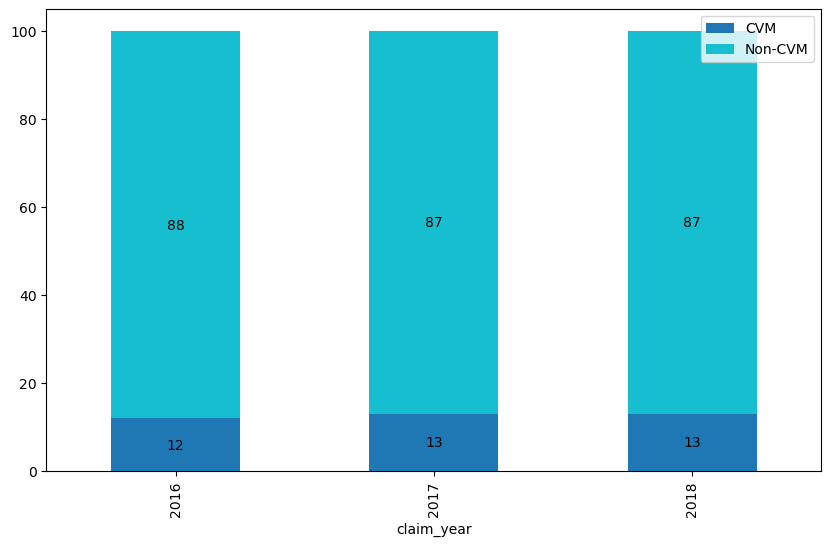

In [71]:
clm_count_by_year_cat_perc_100_stacked_bar_graph = clm_count_by_year_cat_perc_df.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))
for container in clm_count_by_year_cat_perc_100_stacked_bar_graph.containers:
    clm_count_by_year_cat_perc_100_stacked_bar_graph.bar_label(container, label_type='center')

### Business Insights
Based on the analysis of the share of CVM claims as a percentage of total claims over the years 2016 through 2018, the following key business insights can be derived:

1. **Growing CVM Market Share**: The percentage of CVM claims has remained relatively stable from 2016 to 2018, indicating a consistent market demand for treatments related to Cardio Vascular Metabolic (CVM) diseases. This suggests a sustained need for pharmaceutical interventions in this sector.

2. **Competitive Landscape and Market Potential**: Despite the stable share, the CVM market still has room for growth, as the proportion of non-CVM claims remains significantly larger. This highlights an opportunity for strategic market expansion and product development to capture a larger share of the CVM market.

3. **Targeted Marketing and Messaging**: With a steady market share, marketing strategies can be tailored to target healthcare providers (HCPs) who are actively involved in treating CVM diseases. Crafting precise messaging that emphasizes the effectiveness and benefits of CVM-related products and services can effectively engage these HCPs and increase product adoption rates.

4. **Sales Force Optimization**: The consistent share of CVM claims implies a stable customer base for CVM-related pharmaceutical products. Sales and marketing leadership can use this insight to optimize the deployment of their sales force, ensuring that a dedicated team is focused on engaging healthcare providers handling CVM cases to maximize sales and market penetration.

5. **Patient-Centric Approach**: With a significant portion of the market still comprised of non-CVM claims, there is a need for an approach that caters to patient needs comprehensively. Marketing strategies should emphasize patient-centric approaches, highlighting the importance of overall health and the role of CVM medications in promoting a healthy lifestyle.

6. **Market Diversification Strategies**: While CVM claims hold a significant share, the non-CVM claims segment remains substantial. This presents an opportunity for diversification strategies, where the company can consider developing products or services catering to other prevalent health issues to capture a broader market share and reduce dependence on the CVM market alone.

### Other Analysis 1

In [110]:
# Extract the 'patient_age' data from the DataFrame
patient_age_data = cardiac_uniq_df['patient_age']
patient_age_data

0        74
1        34
2        62
3        86
4        85
         ..
12420    65
12421    71
12422    77
12423    77
12424    67
Name: patient_age, Length: 12425, dtype: int64

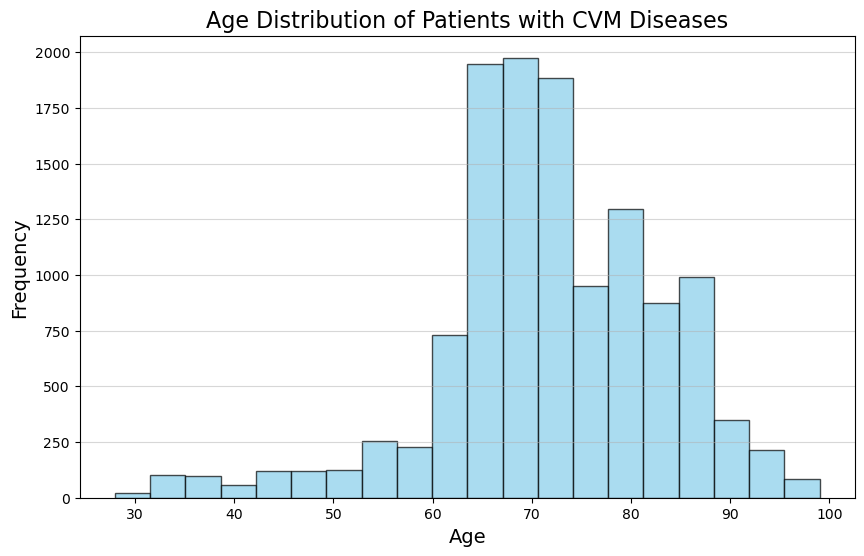

In [111]:
# Create a histogram to visualize the age distribution
plt.figure(figsize=(10, 6))
plt.hist(patient_age_data, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Age Distribution of Patients with CVM Diseases', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', alpha=0.5)
plt.show()

In [162]:
# Calculate the total claim cost for each diagnosis code
top_diagnosis_revenue = cardiac_uniq_df.groupby('diagnosis_code')['claim_cost'].sum().nlargest(20)
top_diagnosis_revenue

diagnosis_code
I2510     334604.89
R079       89372.00
I25110     62848.80
I25119     60928.52
R0789      60733.99
I25118     46080.42
I10        44472.42
R0602      35527.20
I340       27874.50
R9431      22605.27
R55        19355.79
R42        17846.31
I495       17502.80
I350       14676.46
G459       13828.09
I481       12923.38
I509       12385.65
R072       12210.14
R002       11512.58
I313       11014.80
Name: claim_cost, dtype: float64

In [164]:
# Dropping duplicates
cardiac_uniq_df

,claim_id,patient_id,npi_id,claim_date,diagnosis_code,claim_cost,patient_birth_date,patient_gender,claim_year,patient_age
0,1011605,10163,1.578546e+09,2018-01-02,C439,49.51,1944-12-25,M,2018,74
1,1016102,10017,1.306805e+09,2018-01-25,Z79899,78.46,1984-11-23,M,2018,34
2,104681,10174,1.114950e+09,2016-11-19,J441,71.49,1954-04-13,M,2016,62
3,1049025,10200,1.538127e+09,2017-02-21,Z7901,12.12,1931-04-20,M,2017,86
4,1054205,10200,1.649263e+09,2016-02-03,I4891,11.19,1931-04-20,M,2016,85
...,...,...,...,...,...,...,...,...,...,...
12420,995758,132,1.154324e+09,2017-07-28,I119,17.38,1952-05-07,F,2017,65
12421,996710,12670,1.962612e+09,2018-06-13,Z01810,15.94,1947-10-17,F,2018,71
12422,997981,10906,1.922043e+09,2018-12-05,R82998,16.53,1941-06-16,F,2018,77
12423,999055,12505,1.962479e+09,2016-07-23,R9431,21.27,1939-06-30,M,2016,77


In [166]:
# Calculate the frequency of each diagnosis code
top_diagnosis_frequency = cardiac_uniq_df['diagnosis_code'].value_counts().nlargest(20)
top_diagnosis_frequency

I10       1285
I2510      613
E785       512
R079       489
E119       441
E039       342
E782       278
R9431      274
I480       225
R0789      223
I4891      209
R0602      180
E559       172
D649       169
E7800      147
R55        142
R5383      129
E1165      128
R002       120
Z79899     117
Name: diagnosis_code, dtype: int64

In [176]:
# Group the data by diagnosis code and calculate the total claim cost for each code
top_diagnosis_cost = cardiac_uniq_df.groupby('diagnosis_code')['claim_cost'].sum().nlargest(15)
top_diagnosis_cost

diagnosis_code
I2510     334604.89
R079       89372.00
I25110     62848.80
I25119     60928.52
R0789      60733.99
I25118     46080.42
I10        44472.42
R0602      35527.20
I340       27874.50
R9431      22605.27
R55        19355.79
R42        17846.31
I495       17502.80
I350       14676.46
G459       13828.09
Name: claim_cost, dtype: float64

In [177]:
# Group the data by diagnosis code and count the frequency of each code
top_diagnosis_freq = cardiac_uniq_df['diagnosis_code'].value_counts().nlargest(15)
top_diagnosis_freq

I10      1285
I2510     613
E785      512
R079      489
E119      441
E039      342
E782      278
R9431     274
I480      225
R0789     223
I4891     209
R0602     180
E559      172
D649      169
E7800     147
Name: diagnosis_code, dtype: int64

In [ ]:
# Create subplots for the two charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Plot for top 15 diagnosis codes by claim cost
axes[0].bar(top_diagnosis_cost.index, top_diagnosis_cost, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Top 15 Diagnosis Codes by Claim Cost', fontsize=16)
axes[0].set_xlabel('Diagnosis Code', fontsize=14)
axes[0].set_ylabel('Claim Cost', fontsize=14)
for index, value in enumerate(top_diagnosis_cost):
    axes[0].text(index, value, f'{value:.0f}', ha='center', va='bottom', fontsize=9)
axes[0].grid(axis='y', alpha=0.5)

# Plot for top 15 diagnosis codes by frequency of use
axes[1].bar(top_diagnosis_freq.index, top_diagnosis_freq, color='skyblue', edgecolor='black', alpha=0.7)
axes[1].set_title('Top 15 Diagnosis Codes by Frequency of Use', fontsize=16)
axes[1].set_xlabel('Diagnosis Code', fontsize=14)
axes[1].set_ylabel('Frequency', fontsize=14)
for index, value in enumerate(top_diagnosis_freq):
    axes[1].text(index, value, f'{value:.0f}', ha='center', va='bottom', fontsize=9)
axes[1].grid(axis='y', alpha=0.5)

# Adjust layout
plt.tight_layout()
plt.show()

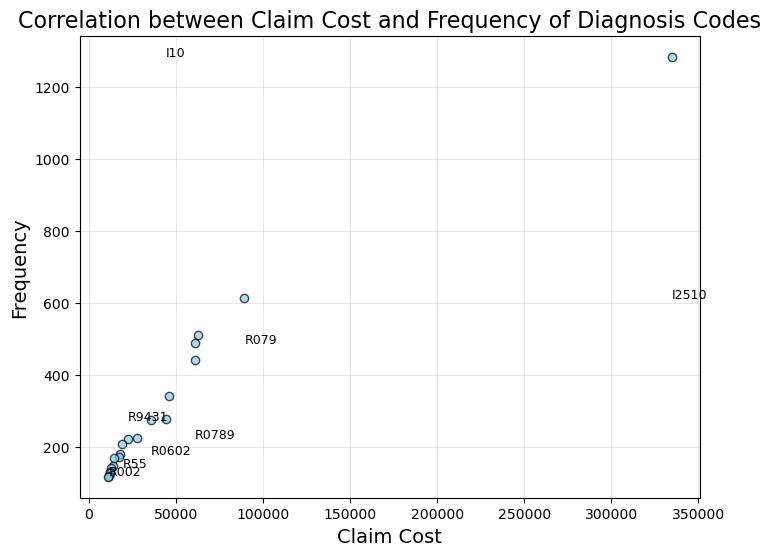

In [172]:
# Group the data by diagnosis code and calculate the total claim cost for each code
top_diagnosis_cost = cardiac_uniq_df.groupby('diagnosis_code')['claim_cost'].sum().nlargest(20)

# Group the data by diagnosis code and count the frequency of each code
top_diagnosis_freq = cardiac_uniq_df['diagnosis_code'].value_counts().nlargest(20)

# Create a scatter plot for the correlation between the two sets of data
plt.figure(figsize=(8, 6))
plt.scatter(top_diagnosis_cost.values, top_diagnosis_freq.values, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Correlation between Claim Cost and Frequency of Diagnosis Codes', fontsize=16)
plt.xlabel('Claim Cost', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Include the diagnosis codes as labels for each data point
for i, code in enumerate(top_diagnosis_cost.index):
    if code in top_diagnosis_freq.index:
        plt.text(top_diagnosis_cost[code], top_diagnosis_freq[code], code, fontsize=9)

plt.grid(alpha=0.3)
plt.show()


## Q2. Evaluate the HCP behavior in context of claim volume from 2016-2018. How many HCPs are submitting 1 CVM claim; how many HCPs are associated with more than 10 claims, etc.? Once you perform this analysis, explain how this trend can influence the sales force deployment. That is, how would you segment the HCPs and how would you allocate In-Person (sales force) vs Non-Personal Promotions (NPP, i.e. Emails, Social Media, Digital etc.) efforts?

### Count the number of cardiac claims per year and provider (NPI)

In [73]:
num_cardiac_clm_by_yr_npi_df = cardiac_uniq_df.groupby(
    ['claim_year', 'npi_id']).agg({'claim_id': 'count'}).reset_index()
num_cardiac_clm_by_yr_npi_df.sort_values('claim_id', ascending=False)

,claim_year,npi_id,claim_id
6942,2018,1.538145e+09,138
7201,2018,1.619913e+09,97
3929,2017,1.538145e+09,84
5422,2018,1.063497e+09,73
4164,2017,1.619913e+09,68
...,...,...,...
2916,2017,1.184611e+09,1
2915,2017,1.184602e+09,1
2914,2017,1.184601e+09,1
2913,2017,1.174638e+09,1


### Categorize the number of claims into different segments: 1, 2-4, 5-9, 10+

In [74]:
cardiac_conditions = [
    (num_cardiac_clm_by_yr_npi_df['claim_id'] == 1),
    (num_cardiac_clm_by_yr_npi_df['claim_id'] >= 2) & (num_cardiac_clm_by_yr_npi_df['claim_id'] < 5),
    (num_cardiac_clm_by_yr_npi_df['claim_id'] >= 5) & (num_cardiac_clm_by_yr_npi_df['claim_id'] < 10),
    (num_cardiac_clm_by_yr_npi_df['claim_id'] >= 10)
]

letters = ['1', '2-4', '5-9', '10+']

num_cardiac_clm_by_yr_npi_df['segment'] = np.select(cardiac_conditions, letters)
num_cardiac_clm_by_yr_npi_df

,claim_year,npi_id,claim_id,segment
0,2016,1.003058e+09,1,1
1,2016,1.003285e+09,1,1
2,2016,1.003802e+09,1,1
3,2016,1.003803e+09,1,1
4,2016,1.003803e+09,1,1
...,...,...,...,...
8347,2018,1.992920e+09,1,1
8348,2018,1.992942e+09,1,1
8349,2018,1.992952e+09,1,1
8350,2018,1.992978e+09,1,1


### Find the number of providers (NPI) per year and bucket, and pivot to have the buckets as columns and the number of providers as values

In [75]:
cardiac_clm_group_by_yr_npi_df = num_cardiac_clm_by_yr_npi_df.groupby(
    ['segment', 'claim_year']
).agg({'npi_id': 'count'}).reset_index().sort_values(['segment','claim_year'])
cardiac_clm_group_by_yr_npi_df

,segment,claim_year,npi_id
0,1,2016,2216
1,1,2017,2486
2,1,2018,2829
3,10+,2016,37
4,10+,2017,34
5,10+,2018,45
6,2-4,2016,166
7,2-4,2017,222
8,2-4,2018,248
9,5-9,2016,23


In [76]:
cardiac_clm_group_by_yr_npi_df = cardiac_clm_group_by_yr_npi_df.pivot(
    index='claim_year', columns='segment', values='npi_id'
).reset_index().rename_axis('Segments', axis=1).set_index('claim_year')[['1', '2-4', '5-9', '10+']]

cardiac_clm_group_by_yr_npi_df = cardiac_clm_group_by_yr_npi_df.rename(
    columns=
    {
        '1': 'Disease_Aware',
        '2-4': 'Trialists',
        '5-9': 'Rising_Stars',
        '10+': 'High-Volume_Prescribers'
    }
)
[['Disease_Aware', 'Trialists', 'Rising_Stars', 'High-Volume_Prescribers']]

cardiac_clm_group_by_yr_npi_df

Segments,Disease_Aware,Trialists,Rising_Stars,High-Volume_Prescribers
claim_year,,,,
2016,2216,166,23,37
2017,2486,222,26,34
2018,2829,248,20,45


### Create a stacked bar graph

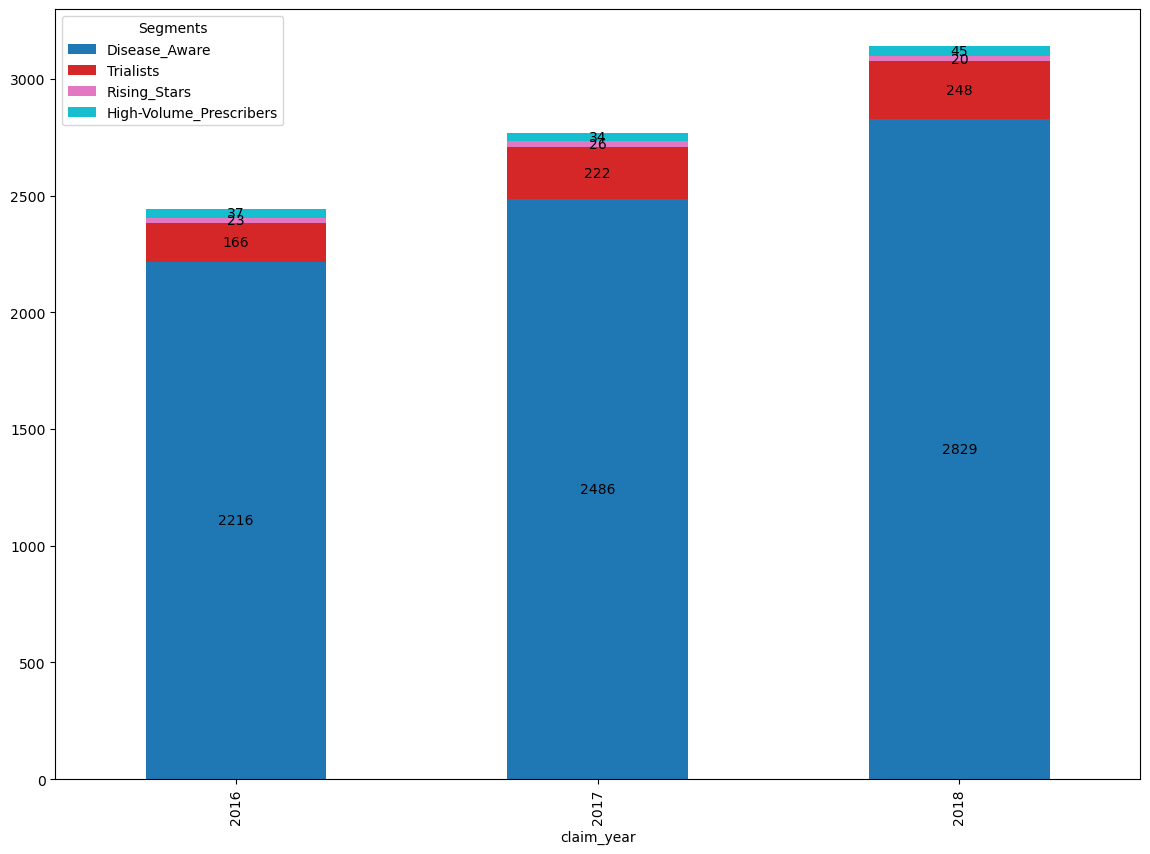

In [77]:
cardiac_clm_group_by_yr_npi_stacked_bar_graph = cardiac_clm_group_by_yr_npi_df.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(14, 10))
for container in cardiac_clm_group_by_yr_npi_stacked_bar_graph.containers:
    cardiac_clm_group_by_yr_npi_stacked_bar_graph.bar_label(container, label_type='center')

### Business Insights
- The overall trend of increasing HCP claim count distribution for CVM medications suggests a growing awareness and interest in these diseases and treatments. This is a positive trend for the pharmaceutical company, as it presents an opportunity to increase sales and improve patient outcomes.

#### Sales Force Deployment
- Segment the HCPs based on their claim count distribution:
  Disease Aware (HCPs with 1 CVM claim)
  Trialists (HCPs with 2-4 CVM claims)
  Rising Stars (HCPs with 5-9 CVM claims)
  High-Volume Prescribers (HCPs with 10+ CVM claims)
- Allocate In-Person sales force efforts to the "High-Volume Prescribers" segment, as these HCPs are the most important targets and require personalized support and services.
- Allocate Non-Personal Promotions (NPP) efforts to the "Disease Aware" and "Trialists" segments, as these HCPs are less familiar with CVM medications and may be more responsive to educational materials and resources. If company has more budget, it may also go with in person promotions by identifying potential HCPs based on demographics.
- The "Rising Stars" segment is a good target for both In-Person and NPP efforts, as these HCPs are already prescribing CVM medications but may be open to trying new products and treatments.

#### Things to consider
- When allocating NPP efforts, consider the HCP's communication preferences and the type of content that is most likely to be relevant and engaging.
- When segmenting the HCPs, be sure to use a unique NPI ID for each HCP. This will help to avoid double counting HCPs who may have multiple NPI IDs in the Medicare dataset.
- When allocating In-Person sales force efforts, consider factors such as the HCP's location, specialty, and practice size. This will help to ensure that the sales force is deployed efficiently and effectively.


## Q3. Evaluate the Patient Age demographics in the context of claim volume from 2016-2018. Bucket the patients into groups based on their age and explain the trends. How would you position the Marketing Budgets and the Promotions with respect to the changing landscape of the CVM claims and the respective patient segments? 

In [78]:
# Deleting the existing patient_age column
cardiac_uniq_df.drop(columns = 'patient_age')
cardiac_uniq_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12425 entries, 0 to 15867
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   claim_id            12425 non-null  int64  
 1   patient_id          12425 non-null  int64  
 2   npi_id              12425 non-null  float64
 3   claim_date          12425 non-null  object 
 4   diagnosis_code      12425 non-null  object 
 5   claim_cost          12425 non-null  float64
 6   patient_birth_date  12425 non-null  object 
 7   patient_gender      12425 non-null  object 
 8   claim_year          12425 non-null  object 
 9   patient_age         12425 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 1.0+ MB


In [79]:
# Calculate patient age at the time of the claim using claim_date and patient_birth_date
cardiac_uniq_df['patient_age'] = pd.to_datetime(cardiac_uniq_df['claim_date']).dt.year - pd.to_datetime(cardiac_uniq_df['patient_birth_date']).dt.year
cardiac_uniq_df

,claim_id,patient_id,npi_id,claim_date,diagnosis_code,claim_cost,patient_birth_date,patient_gender,claim_year,patient_age
0,1011605,10163,1.578546e+09,2018-01-02,C439,49.51,1944-12-25,M,2018,74
1,1016102,10017,1.306805e+09,2018-01-25,Z79899,78.46,1984-11-23,M,2018,34
2,104681,10174,1.114950e+09,2016-11-19,J441,71.49,1954-04-13,M,2016,62
3,1049025,10200,1.538127e+09,2017-02-21,Z7901,12.12,1931-04-20,M,2017,86
4,1054205,10200,1.649263e+09,2016-02-03,I4891,11.19,1931-04-20,M,2016,85
...,...,...,...,...,...,...,...,...,...,...
15863,995758,132,1.154324e+09,2017-07-28,I119,17.38,1952-05-07,F,2017,65
15864,996710,12670,1.962612e+09,2018-06-13,Z01810,15.94,1947-10-17,F,2018,71
15865,997981,10906,1.922043e+09,2018-12-05,R82998,16.53,1941-06-16,F,2018,77
15866,999055,12505,1.962479e+09,2016-07-23,R9431,21.27,1939-06-30,M,2016,77


In [80]:
def assign_segment(age):
    if 18 <= age <= 59:
        return 'Patients with age 18-59'
    elif 60 <= age <= 69:
        return 'Patients with age 60-69'
    elif 70 <= age <= 79:
        return 'Patients with age 70-79'
    elif age >= 80:
        return 'Patients with age 80+'
    else:
        return 'Other'

# Applying the function to create the 'Segment' column
cardiac_uniq_df['Segment'] = cardiac_uniq_df['patient_age'].apply(assign_segment)

# Display the modified DataFrame
print(cardiac_uniq_df)

       claim_id  patient_id        npi_id  claim_date diagnosis_code  \
0       1011605       10163  1.578546e+09  2018-01-02           C439   
1       1016102       10017  1.306805e+09  2018-01-25         Z79899   
2        104681       10174  1.114950e+09  2016-11-19           J441   
3       1049025       10200  1.538127e+09  2017-02-21          Z7901   
4       1054205       10200  1.649263e+09  2016-02-03          I4891   
...         ...         ...           ...         ...            ...   
15863    995758         132  1.154324e+09  2017-07-28           I119   
15864    996710       12670  1.962612e+09  2018-06-13         Z01810   
15865    997981       10906  1.922043e+09  2018-12-05         R82998   
15866    999055       12505  1.962479e+09  2016-07-23          R9431   
15867    999145       11369  1.346285e+09  2018-10-31           I340   

       claim_cost patient_birth_date patient_gender claim_year  patient_age  \
0           49.51         1944-12-25              M     

In [82]:
# Grouping by 'claim_year' and 'Segment' and then counting the number of claims
segment_counts = cardiac_uniq_df.groupby(['claim_year', 'Segment']).size().reset_index(name='Claim_Count')

# Displaying the counts
print(segment_counts)

   claim_year                  Segment  Claim_Count
0        2016  Patients with age 18-59          321
1        2016  Patients with age 60-69         1269
2        2016  Patients with age 70-79         1043
3        2016    Patients with age 80+          929
4        2017  Patients with age 18-59          383
5        2017  Patients with age 60-69         1331
6        2017  Patients with age 70-79         1398
7        2017    Patients with age 80+          928
8        2018  Patients with age 18-59          422
9        2018  Patients with age 60-69         1369
10       2018  Patients with age 70-79         1757
11       2018    Patients with age 80+         1275


In [83]:
# Creating a pivot table with 'claim_year' as index and 'Segment' as columns
pivot_table = cardiac_uniq_df.pivot_table(index='claim_year', columns='Segment', values='claim_id', aggfunc='count')

# Displaying the pivot table
print(pivot_table)

Segment     Patients with age 18-59  Patients with age 60-69  \
claim_year                                                     
2016                            321                     1269   
2017                            383                     1331   
2018                            422                     1369   

Segment     Patients with age 70-79  Patients with age 80+  
claim_year                                                  
2016                           1043                    929  
2017                           1398                    928  
2018                           1757                   1275  


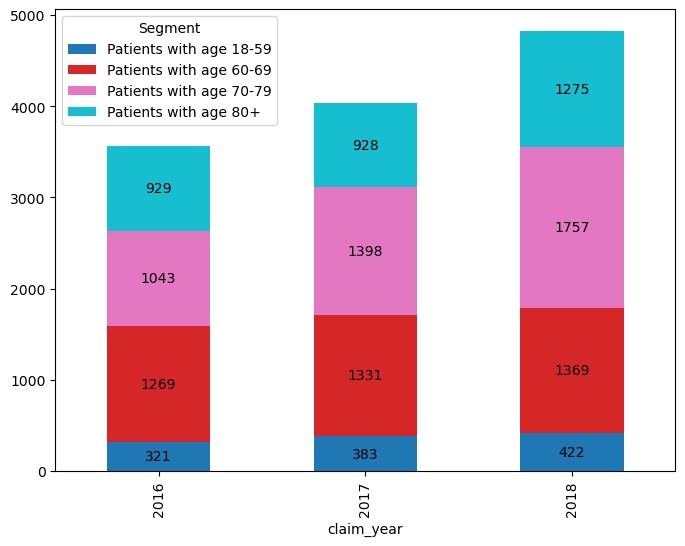

In [84]:
cardiac_clm_group_by_yr_pat_age_stacked_bar_graph = pivot_table.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(8, 6))
for container in cardiac_clm_group_by_yr_pat_age_stacked_bar_graph.containers:
    cardiac_clm_group_by_yr_pat_age_stacked_bar_graph.bar_label(container, label_type='center')

In [96]:
# Convert the index values to integers
pivot_table.index = pivot_table.index.astype(int)

# Calculate the percentage change only if the required indices exist in the pivot table
if all(year in pivot_table.index for year in [2016, 2017, 2018]):
    # Selecting the required rows for years 2016, 2017, and 2018
    pivot_table_selected = pivot_table.loc[[2016, 2017, 2018]]

    # Calculating percentage change between 2016-17 and 2017-18
    percentage_change_16_17 = ((pivot_table_selected.loc[2017] - pivot_table_selected.loc[2016]) / pivot_table_selected.loc[2016]) * 100
    percentage_change_17_18 = ((pivot_table_selected.loc[2018] - pivot_table_selected.loc[2017]) / pivot_table_selected.loc[2017]) * 100

    # Displaying the percentage change
    print("Percentage Change between 2016 and 2017:")
    print(percentage_change_16_17)
    print("\nPercentage Change between 2017 and 2018:")
    print(percentage_change_17_18)
else:
    print("One or more of the required years are not present in the pivot table.")


Percentage Change between 2016 and 2017:
Segment
Patients with age 18-59    19.314642
Patients with age 60-69     4.885737
Patients with age 70-79    34.036433
Patients with age 80+      -0.107643
dtype: float64

Percentage Change between 2017 and 2018:
Segment
Patients with age 18-59    10.182768
Patients with age 60-69     2.854996
Patients with age 70-79    25.679542
Patients with age 80+      37.392241
dtype: float64


In [102]:
import pandas as pd

# Results from the percentage change calculations
data = {
    '2016-17': [19.314642, 4.885737, 34.036433, -0.107643],
    '2017-18': [10.182768, 2.854996, 25.679542, 37.392241]
}

# Index representing the segments
index = pivot_table.columns

# Create the DataFrame
df = pd.DataFrame(data, index=['Patients with age 18-59', 'Patients with age 60-69', 'Patients with age 70-79', 'Patients with age 80+'])

# Transpose the DataFrame to set segments and years as index
df_transposed = df.transpose()

# Display the transposed DataFrame
print(df_transposed)

         Patients with age 18-59  Patients with age 60-69  \
2016-17                19.314642                 4.885737   
2017-18                10.182768                 2.854996   

         Patients with age 70-79  Patients with age 80+  
2016-17                34.036433              -0.107643  
2017-18                25.679542              37.392241  


### Business Insight
**Key Business Insights for Question 3** - The claim volume for CVM medications has increased over time, especially for patients in the 60-69, 70-79, and 80+ age groups. This suggests that these age groups are becoming more important targets for the pharmaceutical company.

**Marketing Budget and Promotions** - The pharmaceutical company should consider allocating more marketing and promotion resources to the 60-69, 70-79, and 80+ age groups. This could be done by increasing the budget for direct mail, email marketing, and educational events for these age groups. The company could also partner with healthcare providers to develop and implement clinical guidelines and educational programs for the treatment of CVM diseases in older adults.

**Marketing and Promotion Strategies** - The pharmaceutical company should focus on the following marketing and promotion strategies for each patient segment:

**Segment 1: 18 – 59**
- Educate patients about the risk factors for CVM diseases and the importance of early detection and treatment.
- Promote healthy lifestyle choices that can help to prevent CVM diseases.
- Offer incentives for patients to get screened for CVM diseases.

**Segment 2: 60 - 69**
- Provide patients with information about the latest CVM treatments and the benefits of these treatments.
- Offer support to patients who are managing CVM diseases.
- Partner with healthcare providers to ensure that patients are receiving the best possible care.

**Segment 3: 70 - 79**
- Help patients to understand their CVM disease and how to manage it effectively.
- Promote treatments that are appropriate for older adults.
- Offer support to patients and their caregivers.

**Segment 4: 80+**
- Provide patients with information about the latest CVM treatments and the benefits of these treatments.
- Help patients to understand their CVM disease and how to manage it effectively.
- Promote treatments that are appropriate for older adults with multiple comorbidities.
- Offer support to patients and their caregivers.

By implementing these marketing and promotion strategies, the pharmaceutical company can reach the right patients with the right messages at the right time. This can help to increase sales and improve patient outcomes.